## imports and installations

In [1]:
!pip install pyspoc

In [2]:
!pip install pyspoc[all]

In [3]:
%env PYDEVD_DISABLE_FILE_VALIDATION=1

env: PYDEVD_DISABLE_FILE_VALIDATION=1


In [4]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [5]:
# install some prerequisite packages for pyspi
!pip install oct2py
!pip install jpype1

In [6]:
from pyspoc import Calculator, Config

octave not found, please see README
Octave not available: octave not found, please see README
Starting JVM with java class C:\Rishi\Maths\Research Project\py-spoc\pyspoc/lib/jidt/infodynamics.jar.
Jpype JVM not available: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.


In [7]:
# import other helper libraries
import pandas as pd
import numpy as np

## data generation

currently just random integers

In [8]:
# generate a random dataframe
df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))

## Simple Example in PySS: using **Statistics** and **Reducers**

https://github.com/garry-cotton/pyss


In [9]:
# create a simple YAML config for pyss

# we first configure the 'Statistics' we want to use
# in this eg, we use the Covariance and the KendallTau correlation coefficient

# we then configure the 'Reducers' we want to use
# in this eg, we use the SingularValues and the Determinant

# for each Reducer function, we determine which Statistic to apply it to reduce

yaml_str_stat_reduce = """
Statistics:
  pyspoc.statistics.basic:
    # Covariance
    Covariance:
      schemes:
        cov:
          estimator: EmpiricalCovariance

    # Kendall Tau correlation coefficient
    KendallTau:
      schemes:
        sq:
          squared: True

        standard:
          squared: False

Reducers:
  pyspoc.reducers.basic:
    SingularValues:
      Statistics:
        - pyspoc.statistics.basic.Covariance.cov
        - pyspoc.statistics.basic.KendallTau.sq
        - pyspoc.statistics.basic.KendallTau.standard
      schemes:
        three:
          num_values: 3

    Determinant:
      Statistics:
        - pyspoc.statistics.basic.Covariance.cov
      schemes:
        scaled:
          scaled: True

        non-scaled:
          scaled: False
"""

In [10]:
# copy the randomly generated dataframe
my_dataset = df.copy()

# set a name for the config
my_config_name = "test_config_yml"
# create a Config class object
cfg = Config.from_yaml(my_config_name, yaml_str_stat_reduce)
# pass the dataframe or numpy array
# constructs a 'Calculator' instance
calc = Calculator(my_dataset, normalise=False)
# run the compute function - applies functions in the config (i.e. in Statistic and Reducer) to the Data
calc.compute(cfg)
# view results
calc.results.T

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic loaded successfully.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic loaded successfully.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 62.10it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 543.35it/s]


Calculation complete. Time taken: 0.0559s


0
Statistic                                   Reducer                                                   
pyspoc.statistics.basic.Covariance.cov      pyspoc.reducers.basic.SingularValues.three_1  1.004165e+03
                                            pyspoc.reducers.basic.SingularValues.three_2  8.045406e+02
                                            pyspoc.reducers.basic.SingularValues.three_3  7.503358e+02
                                            pyspoc.reducers.basic.Determinant.scaled      5.125090e-24
                                            pyspoc.reducers.basic.Determinant.non-scaled  4.417222e+11
pyspoc.statistics.basic.KendallTau.sq       pyspoc.reducers.basic.SingularValues.three_1  1.007152e+00
                                            pyspoc.reducers.basic.SingularValues.three_2  1.000022e+00
                                            pyspoc.reducers.basic.SingularValues.three_3  9.987573e-01
pyspoc.statistics.basic.KendallTau.standard pyspoc.reducers.basic.SingularValues.three_1  1.121689e+00
                                            pyspoc.reducers.basic.SingularValues.three_2  9.983510e-01
                                            pyspoc.reducers.basic.SingularValues.three_3  9.575879e-01

In [11]:
REDUCERS = list(calc.results.columns.values)

## Simple Example in PySS: using **ReducedStatistics**

https://github.com/garry-cotton/pyss

to illustrate the use of the ReducedStatistics, we use two PCA-based statistics and one inherited from the Statistics class (since any Statistic can be used as a ReducedStatistic also)

more Statistics, Reducers, and ReducedStatistics can be added similarly to how it's done for ReducedStatistics in ```pyss/rstatistics/test.py```

In [12]:
yaml_reducedStat = """
ReducedStatistics:
  pyspoc.rstatistics.pca:
    PCAVarianceExplainedRatio:
      schemes:
        std:
          components:
            - 2
            - 4

    PCAEigenVectors:
      schemes:
        std:
          principal_vectors:
            - 1
            - 3

  pyspoc.rstatistics.test:
    ReducedCovarianceTest:
      schemes:
        cov:
          estimator: EmpiricalCovariance

"""

In [13]:
# # copy the randomly generated dataframe
# my_dataset_rs = df.copy()

# # set a name for the config
# my_config_name_rs = "test_config_yml_rs"

In [14]:
# # create a Config class object
# cfg_rs = Config.from_yaml(my_config_name_rs, yaml_reducedStat)

In [15]:
# # pass the dataframe or numpy array
# # constructs a 'Calculator' instance
# calc_rs = Calculator(my_dataset_rs)

In [16]:
# # run the compute function - applies functions in the config (i.e. in Statistic and Reducer) to the Data
# calc_rs.compute(cfg_rs)

In [17]:
# # view results
# calc_rs.results.T

##Functions to Load and manipulate dataframe as appropriate

In [18]:
import numpy as np
import pandas as pd
import scipy.stats
from typing import List, Dict, Union, Callable, Optional, Any, Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.figure import Figure
from tqdm.notebook import tqdm
#from pyspi.calculator import Calculator
from matplotlib.backends.backend_pdf import PdfPages

def load_data(filename: str, skip: int = 1) -> pd.DataFrame:
    """
    Load data from a CSV file.
    NOTE THAT THIS RETURNS THE TRANSPOSED DATAFRAME!
    Parameters:
    -----------
    filename : str
        Path to the CSV file.
    skip : int, optional
        Number of columns to skip, by default 1
    normalize : str, optional
        The method to use for scaling. Options are:
        - 'z-score': Z-Score Normalization (StandardScaler)
        - 'min-max': Min-Max Normalization (MinMaxScaler)
        - 'robust': Robust Scaling using median and IQR (RobustScaler)
        - None: No scaling (default)

    Returns:
    --------
    pd.DataFrame
        The loaded and optionally normalized data.
    """
    df = pd.read_csv(filename)
    df = df.transpose()
    df = df.iloc[skip:]
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()


    return df


def normalize_data(data: pd.DataFrame, method: str = 'z-score') -> pd.DataFrame:
    """
    Normalize the data using the specified method.

    Parameters:
    -----------
    data : pd.DataFrame
        The data to normalize.
    method : str, optional
        The method to use for scaling. Options are:
        - 'z-score': Z-Score Normalization (StandardScaler)
        - 'min-max': Min-Max Normalization (MinMaxScaler)
        - 'robust': Robust Scaling using median and IQR (RobustScaler)

    Returns:
    --------
    pd.DataFrame
        The normalized data.
    """
    normalized = data.copy()

    # Select the appropriate scaler based on the method
    if method == 'z-score':
        scaler = StandardScaler()
    elif method == 'min-max':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown normalization method: {method}. "
                         f"Choose from 'z-score', 'min-max', or 'robust'.")

    # Apply the scaler to the data
    normalized_values = scaler.fit_transform(normalized)
    normalized = pd.DataFrame(normalized_values,
                             index=normalized.index,
                             columns=normalized.columns)

    return normalized


def shuffle_data(df: pd.DataFrame, random_seed=None) -> pd.DataFrame:
    """
    Returns a new DataFrame with each row's elements shuffled independently.

    Parameters:
    - df: The input pandas DataFrame.
    - random_state: Optional seed for reproducibility.

    Returns:
    - A new DataFrame with rows shuffled.
    """
    rng = np.random.default_rng(seed=random_seed)
    return pd.DataFrame(
        [rng.permutation(row) for row in df.to_numpy()],
        columns=df.columns,
        index=df.index
    )

def perturb_dataframe(df, scale_factor=0.1, random_seed=None):
    """
    Vectorized version of perturb_dataframe for better performance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing numeric values
    scale_factor : float, default=0.1
        Scaling factor for the perturbation
    random_seed : int, optional
        Random seed for reproducible results
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with perturbed values
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Calculate row variances
    row_variances = df.var(axis=1, ddof=1)
    row_variances = np.maximum(row_variances, 1e-6)  # Minimum variance
    
    # Calculate perturbation standard deviations
    perturbation_stds = scale_factor * np.sqrt(row_variances)
    
    # Create perturbation matrix
    perturbations = np.random.normal(0, 1, size=df.shape)
    
    # Scale perturbations by row-specific standard deviations
    for i in range(df.shape[0]):
        perturbations[i] *= perturbation_stds.iloc[i]
    
    # Add perturbations to original data
    perturbed_df = df + perturbations
    
    return perturbed_df

##Applying reducers to dataframe

In [19]:
#defining reducers
REDUCERS = list(calc.results.columns.values)
for reducer in REDUCERS:
    print(calc.results[reducer].values[0])

1004.164763412499
804.5406096142966
750.335821503648
5.125090371823656e-24
441722209756.3942
1.007152383038774
1.0000224414750407
0.9987573452307288
1.1216885518836321
0.9983510346574037
0.9575879476136366


In [20]:
def apply_reducer(calc, reducer) -> float:
    """
    Apply a specific reducer to a matrix and get a value, useful for iterating

    Parameters:
    -----------
    calc : Calculator
        The calculator instance.
    reducer : gets reducer value from calc.results

    Returns:
    --------
    float
        The reduced value.
    """
    return calc.results[reducer].values[0]


def pyspi_calc(name,config_name, yaml,skip=1, normalize=None, shuffle=False, perturb=False,scale_factor=0.1,random_seed=None):
    """
    Calculate covariance and other statistics from a CSV file.

    Parameters:
    - name: CSV filename
    - config_name: Name of the configuration file
    - yaml: YAML string for configuration
    - skip: Number of columns to skip (default: 1)
    - normalize: Method to normalize data (default: None)
    - shuffle: Whether to randomly shuffle rows (default: False)
    - random_seed: Seed for reproducible shuffling (default: None)

    Returns:
    - Calc results table
    """

    # Load data with normalization
    df = load_data(filename=name, skip=skip)

    # If shuffle is requested, shuffle the data
    if shuffle:
        df = shuffle_data(df, random_seed=random_seed)

    # If perturb is requested, add random noise to the data
    if perturb:
        df = perturb_dataframe(df, scale_factor=scale_factor, random_seed=random_seed)
    if normalize is not None:
        df = normalize_data(df, method=normalize)
    df = df.transpose()  # Transpose to match expected format
    cfg = Config.from_yaml(config_name, yaml)
    # Use Calculator class to compute the statistics
    # pass the dataframe or numpy array
    # constructs a 'Calculator' instance
    calc = Calculator(df, normalise=False)
    # run the compute function - applies functions in the config (i.e. in Statistic and Reducer) to the Data
    calc.compute(cfg)
    return calc.results


In [21]:
def permutation_test(
    filename: str,
    config_name,
    yaml,
    calc,
    n_permutations: int = 1000,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    save_permutation_data: bool = True,
    orig_calc_table: Optional[Dict] = None,
) -> Dict[str, Dict[str, Any]]:
    """
    Perform a permutation test to assess statistical significance and calculate variance.
    """
    REDUCERS = list(calc.columns.values)
    # Use provided orig_calc_table or compute
    if orig_calc_table is None:
        orig_calc_table = pyspi_calc(filename, config_name, yaml,skip=skip, normalize=normalize)

    orig_results = {
        reducer: orig_calc_table[reducer].values[0] for reducer in REDUCERS
    }
    
    perm_values = {reducer: [] for reducer in REDUCERS}

    # Run permutations with progress bar
    iter_range = tqdm(range(n_permutations))
    for i in iter_range:
        # Use different random seed for each perm
        perm_seed = None if random_seed is None else random_seed + i + 1
        # Get shuffled data statistics
        perm_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize, shuffle=True, random_seed=perm_seed)

        for reducer in REDUCERS:
            perm_value = perm_calc_table[reducer].values[0]
            # Append the value to the list
            perm_values[reducer].append(perm_value)

    # Calculate p-values, variances, and add to results
    # Create the DataFrame of permutation results AFTER collecting all values
    # The index length should match the number of permutations
    perm_data = pd.DataFrame(perm_values)
    # Calculate p-values, variances, and add to results
    final_results = {}
    for reducer in REDUCERS:
        # Access the specific reducer's data from the perm_data DataFrame
        perm_data_series = perm_data[reducer]
        orig_value = orig_results[reducer]
        n = len(perm_data_series) # Use the length of the collected data

        # Calculate permutation percentile for p-value
        lower_tail = np.sum(perm_data_series < orig_value) / n
        upper_tail = np.sum(perm_data_series > orig_value) / n
        permutation_percentile = min(lower_tail, upper_tail)
        p_value = permutation_percentile * 2 # Multiply by 2 for a two-tailed test

        result = {'value': orig_value,
              'p_value': p_value}

        # Update results with permutation statistics
        result.update({
            'permutation_mean': np.mean(perm_data_series),
            'permutation_median': np.median(perm_data_series),
            'permutation_std': np.std(perm_data_series),
            'permutation_std_err': np.std(perm_data_series) / np.sqrt(n),
            'permutation_variance': np.var(perm_data_series),
            'permutation_min': np.min(perm_data_series),
            'permutation_max': np.max(perm_data_series),
            'permutation_distribution': perm_data_series.tolist() if save_permutation_data else None, # Store as list if needed
            'permutation_percentile_rank': permutation_percentile
        })

        final_results[reducer] = result
    return final_results


def plot_permutation_distribution(results: Dict, reducer: str,
                                 figsize: Tuple[int, int] = (10, 6)) -> Figure:
    """
    Plot the distribution of permutation test values

    Parameters:
    -----------
    results : Dict
        Dictionary containing permutation test results.
    reducer : str
        Name of the reducer
    figsize : Tuple[int, int], optional
        Figure size (width, height), by default (10, 6)

    Returns:
    --------
    Figure
        Matplotlib figure object.
    """

    # Extract data
    result = results[reducer]
    perm_values = result['permutation_distribution']
    orig_value = result['value']
    p_value = result['p_value']

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of permutation values
    n, bins, patches = ax.hist(perm_values, bins=30, alpha=0.7, color='skyblue',
                              edgecolor='black', density=True)

    # Add kernel density estimate
    sns.kdeplot(perm_values, color='navy', ax=ax, linewidth=2)

    # Add vertical line for original value
    ax.axvline(x=orig_value, color='red', linestyle='--', linewidth=2,
              label=f'Original value: {orig_value:.4f}')

    # Add permutation statistics
    stats_text = (
        f"Permutation Stats:\n"
        f"Mean: {result['permutation_mean']:.4f}\n"
        f"Median: {result['permutation_median']:.4f}\n"
        f"Std Dev: {result['permutation_std']:.4f}\n"
        f"Std Err: {result['permutation_std_err']:.4f}\n"
        f"p-value: {p_value:.4f}"
    )

    # Add the stats text as an annotation
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add labels and title
    ax.set_xlabel(f'{reducer} Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Permutation Distribution for {reducer}')

    ax.legend()
    fig.tight_layout()

    return fig


def plot_all_permutation_distributions(results: Dict, figsize: Tuple[int, int] = (12, 8)) -> Dict[str, Figure]:
    figures = {}
    for reducer_name, reducer_results in results.items():
        # Convert reducer_name to string for safe dict key
        key = str(reducer_name)
        if (isinstance(reducer_results, dict) and
            'permutation_distribution' in reducer_results and
            'value' in reducer_results):
            try:
                fig = plot_permutation_distribution(results, reducer_name, figsize=figsize)
                figures[key] = fig
            except Exception as e:
                print(f"Error plotting {reducer_name}: {e}")
    return figures


In [22]:
normalize = 'z-score'
random_seed = 42
orig_calc_table = pyspi_calc("unemployment_rate_by_age_groups.csv", "test_config_yml",yaml_str_stat_reduce,skip=5, normalize=normalize)


print(permutation_test(
    "unemployment_rate_by_age_groups.csv",
    "test_config_yml",
    yaml_str_stat_reduce,
    orig_calc_table,
    n_permutations=5,
    skip=5,
    normalize=normalize,
    random_seed=random_seed,
    save_permutation_data=True,
    orig_calc_table=orig_calc_table
))

permutation_results = permutation_test(
    "unemployment_rate_by_age_groups.csv",
    "test_config_yml",
    yaml_str_stat_reduce,
    orig_calc_table,
    n_permutations=5,
    skip=5,
    normalize=normalize,
    random_seed=random_seed,
    save_permutation_data=True,
    orig_calc_table=orig_calc_table
)


Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 61.49it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 672.81it/s]


Calculation complete. Time taken: 0.0553s


  0%|          | 0/5 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 51.88it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 235.83it/s]



Calculation complete. Time taken: 0.0726s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 50.12it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 340.40it/s]



Calculation complete. Time taken: 0.0707s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 48.81it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 235.33it/s]



Calculation complete. Time taken: 0.0763s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 47.44it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 288.78it/s]



Calculation complete. Time taken: 0.0768s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 48.87it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 264.57it/s]



Calculation complete. Time taken: 0.0739s
{('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_1'): {'value': 0.05041400639954374, 'p_value': 0.0, 'permutation_mean': 0.5606488902743869, 'permutation_median': 0.5720678501858559, 'permutation_std': 0.04509330506292644, 'permutation_std_err': 0.020166339090167792, 'permutation_variance': 0.0020334061614981475, 'permutation_min': 0.4775631699005906, 'permutation_max': 0.6067405862488252, 'permutation_distribution': [0.5720678501858559, 0.6067405862488252, 0.4775631699005906, 0.5549713902624908, 0.5919014547741716], 'permutation_percentile_rank': 0.0}, ('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_2'): {'value': 0.010685664301292164, 'p_value': 0.0, 'permutation_mean': 0.2613706640063394, 'permutation_median': 0.2577292373775336, 'permutation_std': 0.011325793723335463, 'permutation_std_err': 0.005065048932903708, 'permutation_variance': 0.00012827360346354496, 'p

  0%|          | 0/5 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.56it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 223.62it/s]



Calculation complete. Time taken: 0.0872s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 47.06it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 263.74it/s]



Calculation complete. Time taken: 0.0774s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.92it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 143.24it/s]



Calculation complete. Time taken: 0.0955s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 32.80it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 215.06it/s]



Calculation complete. Time taken: 0.1064s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 26.86it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 187.98it/s]


Calculation complete. Time taken: 0.1306s


In [23]:
# Plot all permutation distributions
#print(plot_all_permutation_distributions(permutation_results)[('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_1')])


In [24]:
def bootstrap_sample_data(df: pd.DataFrame, sample_fraction: float = 0.9, random_seed: Optional[int] = None) -> pd.DataFrame:
    """
    Create a bootstrap sample from the dataframe by sampling a fraction of columns with replacement.

    Parameters:
    -----------
    df : pd.DataFrame
        The original dataframe
    sample_fraction : float, optional
        Fraction of columns to sample
    random_seed : Optional[int], optional
        Random seed for reproducibility

    Returns:
    --------
    pd.DataFrame
        Bootstrap sampled dataframe (columns)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Calculate number of columns to sample
    n_samples = int(len(df.columns) * sample_fraction)

    # Sample columns with replacement
    sampled_columns = np.random.choice(df.columns, size=n_samples, replace=True)

    # Create bootstrap sample with selected columns
    bootstrap_df = df.loc[:, sampled_columns].copy()
    return bootstrap_df


def pyspi_calc_bootstrap(name: str,config_name: str, yaml,skip: int = 1, normalize: Optional[str] = None,
                        sample_fraction: float = 0.9, random_seed: Optional[int] = None):
    """
    Calculate covariance and other statistics from a CSV file using bootstrap sampling.

    Parameters:
    -----------
    name : str
        CSV filename
    config_name: str
        Name of the configuration file
    yaml : YAML string for configuration
    skip : int, optional
        Number of columns to skip (default: 1)
    normalize : Optional[str], optional
        Method to normalize data (default: None)
    sample_fraction : float, optional
        Fraction of rows to sample for bootstrap (default: 0.9)
    random_seed : Optional[int], optional
        Seed for reproducible sampling (default: None)

    Returns:
    --------
    Dictionary of calculated statistics
    """
    # Load data 
    df = load_data(filename=name, skip=skip)

    # Create bootstrap sample
    bootstrap_df = bootstrap_sample_data(df, sample_fraction=sample_fraction, random_seed=random_seed)
    if normalize is not None:
        bootstrap_df = normalize_data(bootstrap_df, method=normalize)
    bootstrap_df = bootstrap_df.transpose()  # Transpose to match expected format
    # Use Calculator class to compute the statistics
    cfg = Config.from_yaml(config_name, yaml)
    calc = Calculator(bootstrap_df, normalise=False)
    calc.compute(cfg)
    return calc.results


def bootstrap_test(
    filename: str,
    config_name,
    yaml,
    calc,
    n_bootstrap: int = 1000,
    sample_fraction: float = 0.9,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    save_bootstrap_data: bool = True,
    orig_calc_table: Optional[Dict] = None,  
) -> Dict[str, Dict[str, Dict[str, Any]]]:
    """
    Perform bootstrap sampling test to assess variability of statistics.
    """
    REDUCERS = list(calc.columns.values)
    # Use provided orig_calc_table or compute if not given
    if orig_calc_table is None:
        orig_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize)
    
    orig_results = {
        reducer: orig_calc_table[reducer].values[0] for reducer in REDUCERS
    }
    
    # Store bootstrap values for variance calculation and plotting
    bootstrap_values = {reducer: [] for reducer in REDUCERS}

    # Run bootstrap samples with progress bar
    iter_range = tqdm(range(n_bootstrap), desc="Bootstrap sampling")
    for i in iter_range:
        # Use different random seed for each bootstrap sample
        bootstrap_seed = None if random_seed is None else random_seed + i + 1
        # Get bootstrap sample statistics
        bootstrap_calc_table = pyspi_calc_bootstrap(filename, config_name,yaml,skip=skip, normalize=normalize,
                                                   sample_fraction=sample_fraction, random_seed=bootstrap_seed)

        for reducer_name in REDUCERS:
            try:
                bootstrap_value = bootstrap_calc_table[reducer_name].values[0]
                bootstrap_values[reducer_name].append(bootstrap_value)
            except:
                continue
            
    # Calculate bootstrap statistics and add to results
    final_results = {}
    for reducer_name in REDUCERS:
        orig_value = orig_results[reducer_name]
        result = {
            'original_value': orig_value,
            'n_bootstrap': n_bootstrap,
            'sample_fraction': sample_fraction
        }

        if save_bootstrap_data and bootstrap_values[reducer_name]:
            bootstrap_data = bootstrap_values[reducer_name]

            # Calculate confidence intervals (2.5% and 97.5% percentiles for 95% CI)
            ci_lower = np.percentile(bootstrap_data, 2.5)
            ci_upper = np.percentile(bootstrap_data, 97.5)

            result.update({
                'bootstrap_mean': np.mean(bootstrap_data),
                'bootstrap_median': np.median(bootstrap_data),
                'bootstrap_std': np.std(bootstrap_data),
                'bootstrap_variance': np.var(bootstrap_data),
                'bootstrap_std_err': np.std(bootstrap_data) / np.sqrt(len(bootstrap_data)),
                'bootstrap_min': np.min(bootstrap_data),
                'bootstrap_max': np.max(bootstrap_data),
                'bootstrap_ci_lower': ci_lower,
                'bootstrap_ci_upper': ci_upper,
                'bootstrap_distribution': bootstrap_data if save_bootstrap_data else None,
                'original_in_ci': ci_lower <= orig_value <= ci_upper,
                'bias': np.mean(bootstrap_data) - orig_value,
                'coefficient_of_variation': np.std(bootstrap_data) / np.abs(np.mean(bootstrap_data)) * 100 if np.mean(bootstrap_data) != 0 else np.nan
            })

        final_results[reducer_name] = result

    return final_results


def plot_bootstrap_distribution(results: Dict, reducer,
                               figsize: Tuple[int, int] = (10, 6)) -> Figure:
    """
    Plot the distribution of bootstrap test values

    Parameters:
    -----------
    results : Dict
        Dictionary containing bootstrap test results.
    reducer : str
        Name of the reducer
    figsize : Tuple[int, int], optional
        Figure size (width, height), by default (10, 6)

    Returns:
    --------
    Figure
        Matplotlib figure object.
    """
    # Extract data
    result = results[reducer]
    bootstrap_values = result['bootstrap_distribution']
    orig_value = result['original_value']
    ci_lower = result['bootstrap_ci_lower']
    ci_upper = result['bootstrap_ci_upper']

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of bootstrap values
    n, bins, patches = ax.hist(bootstrap_values, bins=30, alpha=0.7, color='lightgreen',
                              edgecolor='black', density=True)

    # Add kernel density
    sns.kdeplot(bootstrap_values, color='darkgreen', ax=ax, linewidth=2)

    # Add vertical line for original value
    ax.axvline(x=orig_value, color='red', linestyle='--', linewidth=2,
              label=f'Original value: {orig_value:.4f}')

    # Add confidence interval lines
    ax.axvline(x=ci_lower, color='orange', linestyle=':', linewidth=2,
              label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle=':', linewidth=2)

    # Fill confidence interval area
    ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='orange')

    # Add bootstrap statistics
    stats_text = (
        f"Bootstrap Stats:\n"
        f"Mean: {result['bootstrap_mean']:.4f}\n"
        f"Median: {result['bootstrap_median']:.4f}\n"
        f"Std Dev: {result['bootstrap_std']:.4f}\n"
        f"Std Err: {result['bootstrap_std_err']:.4f}\n"
        f"Bias: {result['bias']:.4f}\n"
        f"CV: {result['coefficient_of_variation']:.2f}%\n"
        f"Original in CI: {result['original_in_ci']}"
    )

    # Add the stats text as an annotation
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add labels and title
    ax.set_xlabel(f'{reducer} Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Row Bootstrap Distribution for {reducer}')

    # Add subtitle with sample info
    subtitle = f'Row Bootstrap samples: {result["n_bootstrap"]}, Sample fraction: {result["sample_fraction"]:.1%}'
    ax.text(0.5, 0.98, subtitle, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', horizontalalignment='center', style='italic')

    ax.legend()
    fig.tight_layout()

    return fig


def plot_all_bootstrap_distributions(results: Dict, figsize: Tuple[int, int] = (12, 8)) -> Dict[str, Figure]:
    figures = {}
    for reducer_name, reducer_results in results.items():
        key = str(reducer_name)
        try:
            fig = plot_bootstrap_distribution(results, reducer_name, figsize=figsize)
            figures[key] = fig
        except Exception as e:
            print(f"Error plotting bootstrap {reducer_name}: {e}")
    return figures

In [25]:
normalize = 'z-score'
random_seed = 42
orig_calc_table = pyspi_calc("unemployment_rate_by_age_groups.csv", "test_config_yml",yaml_str_stat_reduce,skip=5, normalize=normalize)

print(bootstrap_test(
    "unemployment_rate_by_age_groups.csv",
    "test_config_yml",
    yaml_str_stat_reduce,
    orig_calc_table,
    n_bootstrap=3,
    skip=5,
    normalize=normalize,
    random_seed=random_seed,
    save_bootstrap_data=True,
    orig_calc_table=orig_calc_table
))

bootstrap_results = bootstrap_test(
    "unemployment_rate_by_age_groups.csv",
    "test_config_yml",
    yaml_str_stat_reduce,
    orig_calc_table,
    n_bootstrap=3,
    skip=5,
    normalize=normalize,
    random_seed=random_seed,
    save_bootstrap_data=True,
    orig_calc_table=orig_calc_table
)

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 31.37it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 560.26it/s]


Calculation complete. Time taken: 0.1046s


Bootstrap sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 27.15it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 240.02it/s]



Calculation complete. Time taken: 0.1268s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 31.51it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 207.66it/s]



Calculation complete. Time taken: 0.1139s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 32.95it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 197.46it/s]


Calculation complete. Time taken: 0.1086s
{('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_1'): {'original_value': 0.05041400639954374, 'n_bootstrap': 3, 'sample_fraction': 0.9, 'bootstrap_mean': 0.05137833891670232, 'bootstrap_median': 0.052800153758356214, 'bootstrap_std': 0.007963786545178772, 'bootstrap_variance': 6.342189613717045e-05, 'bootstrap_std_err': 0.0045978943056276846, 'bootstrap_min': 0.04099186039527385, 'bootstrap_max': 0.06034300259647688, 'bootstrap_ci_lower': 0.04158227506342797, 'bootstrap_ci_upper': 0.059965860154570845, 'bootstrap_distribution': [0.06034300259647688, 0.052800153758356214, 0.04099186039527385], 'original_in_ci': True, 'bias': 0.0009643325171585782, 'coefficient_of_variation': 15.500280299233001}, ('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_2'): {'original_value': 0.010685664301292164, 'n_bootstrap': 3, 'sample_fraction': 0.9, 'bootstrap_mean': 0.011238740136966673,

Bootstrap sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 30.81it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 210.28it/s]



Calculation complete. Time taken: 0.1157s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 20.04it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 138.07it/s]



Calculation complete. Time taken: 0.1759s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.74it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 144.99it/s]


Calculation complete. Time taken: 0.1293s


{"('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_1')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_2')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_3')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.scaled')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.non-scaled')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_1')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_2')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_3

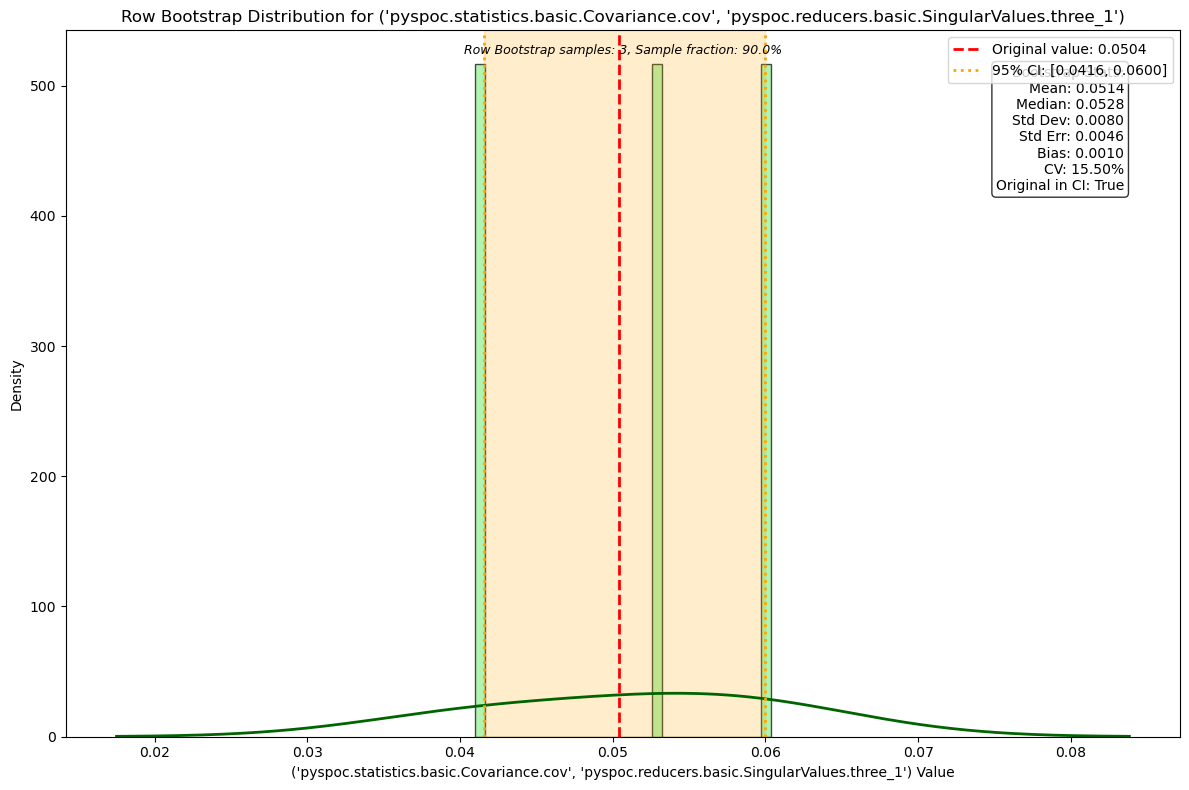

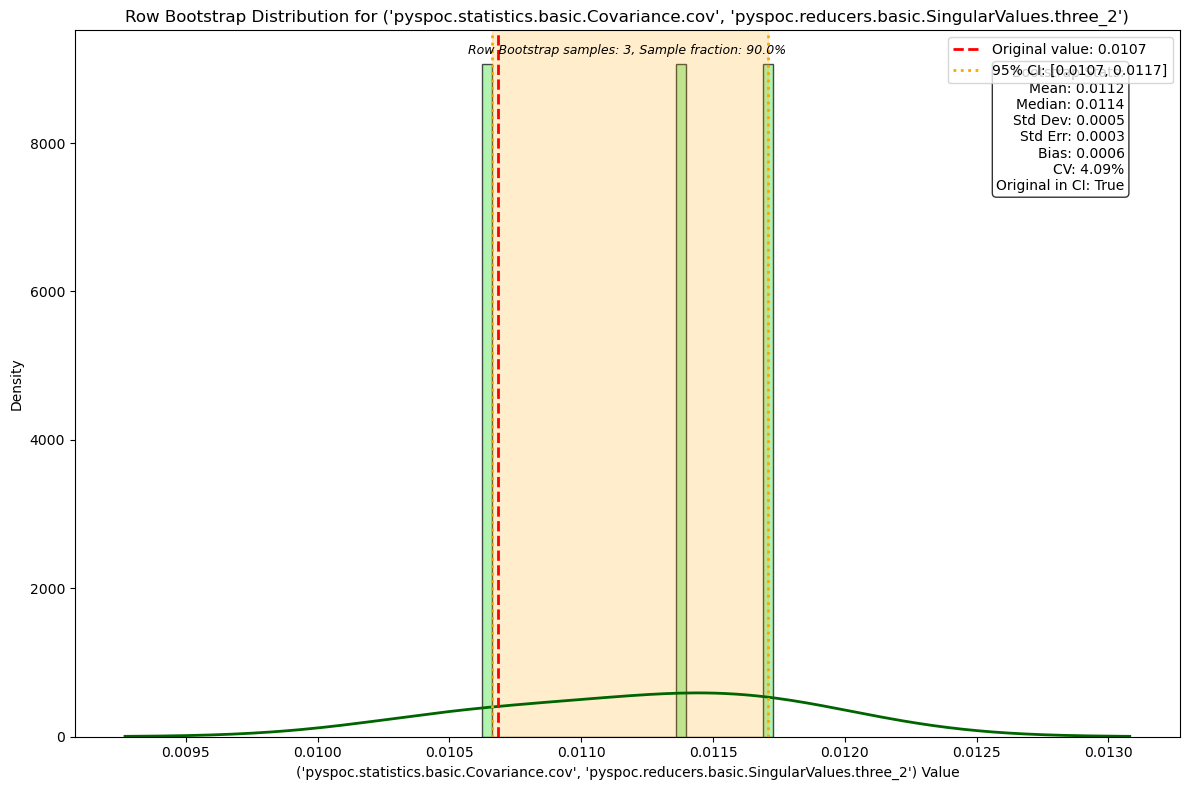

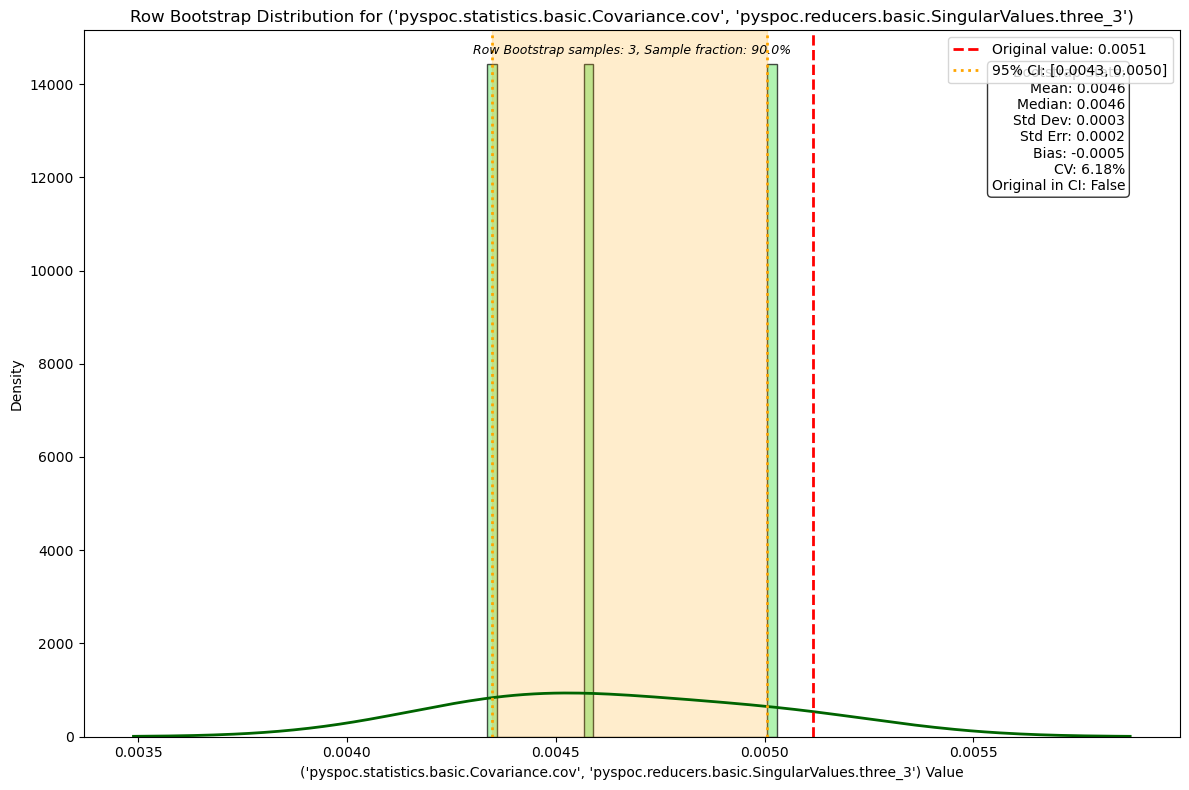

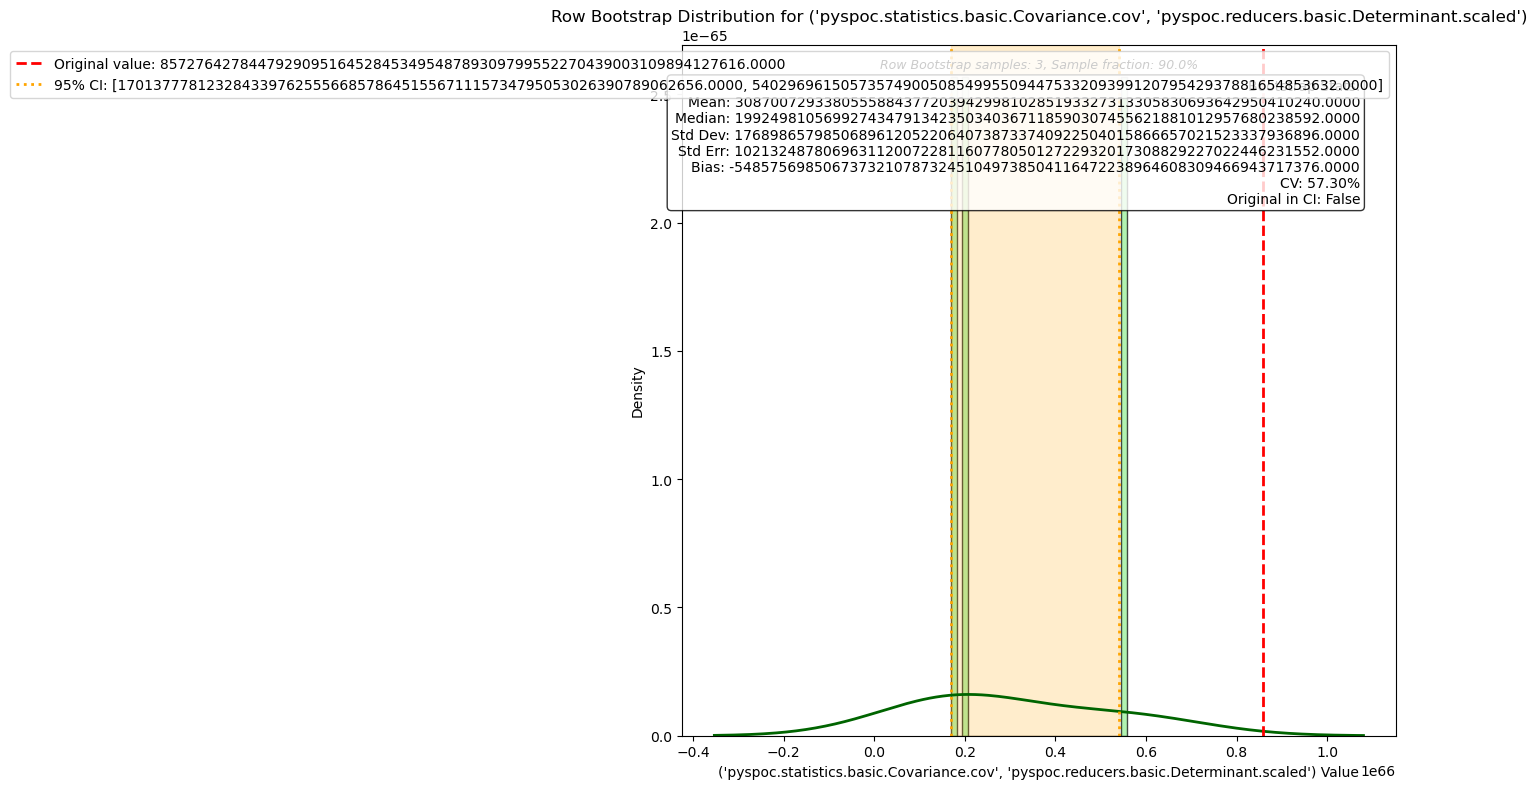

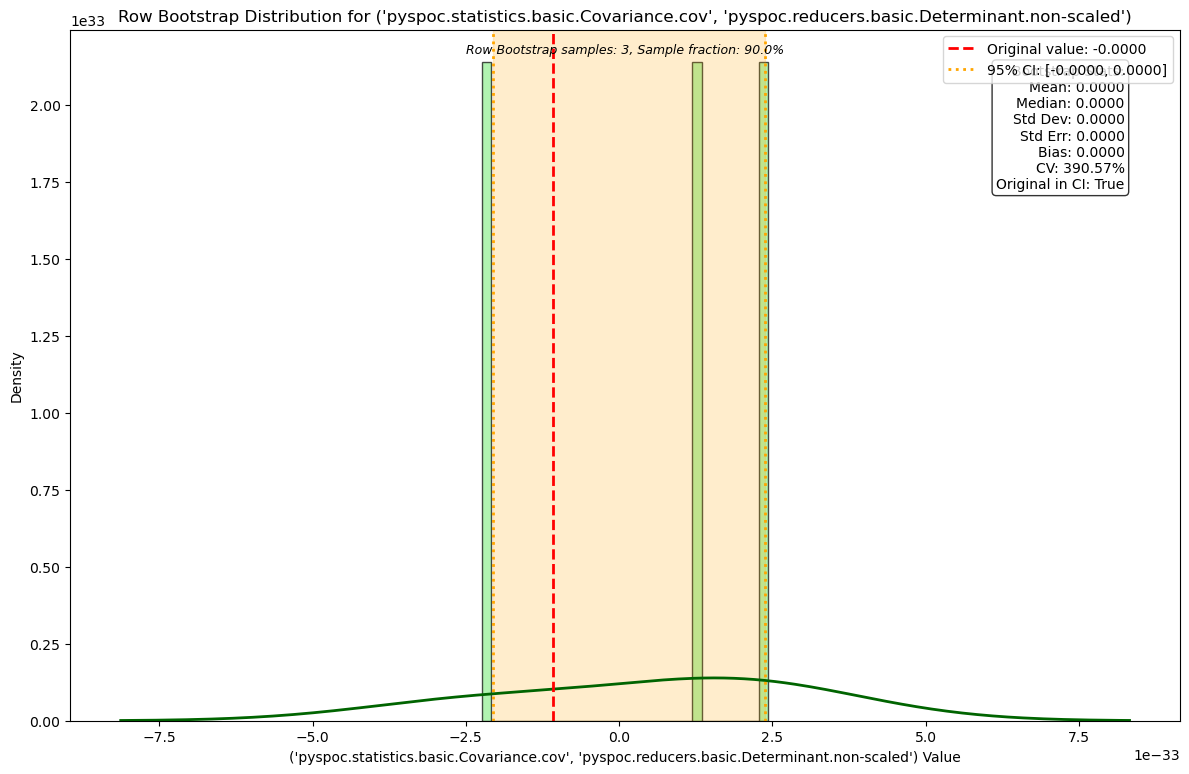

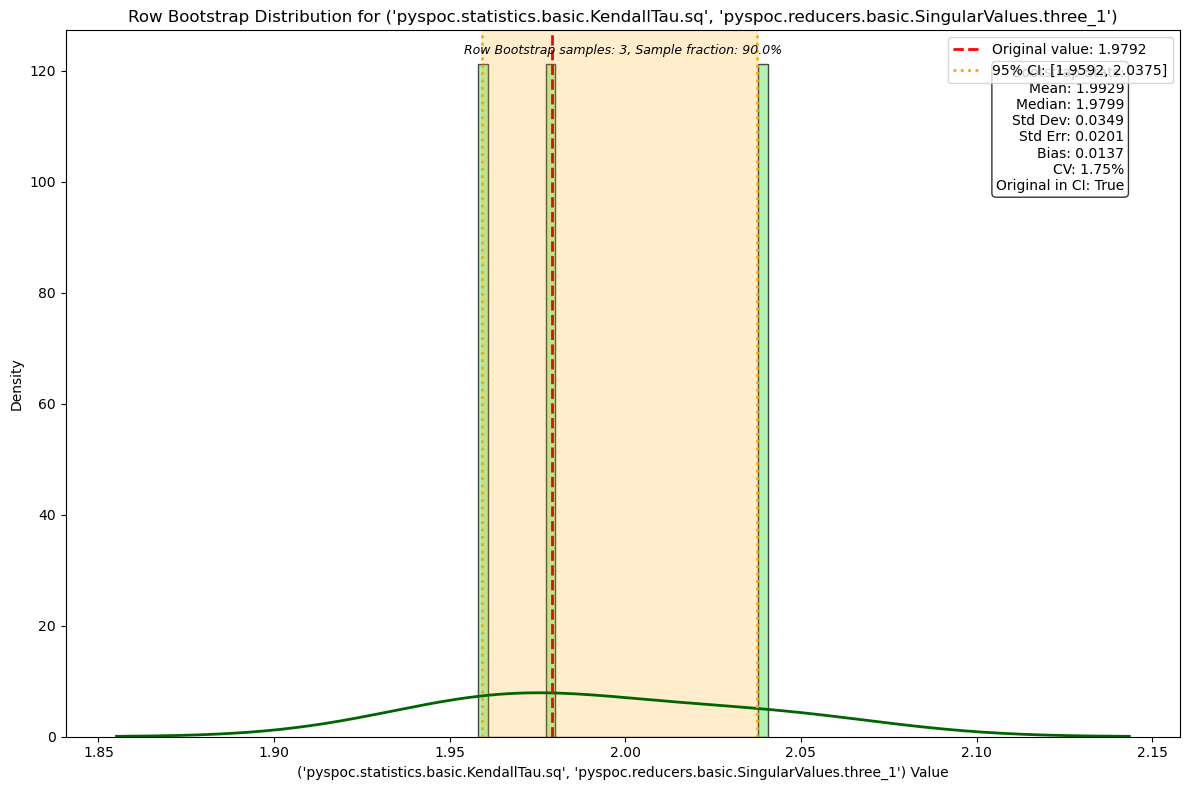

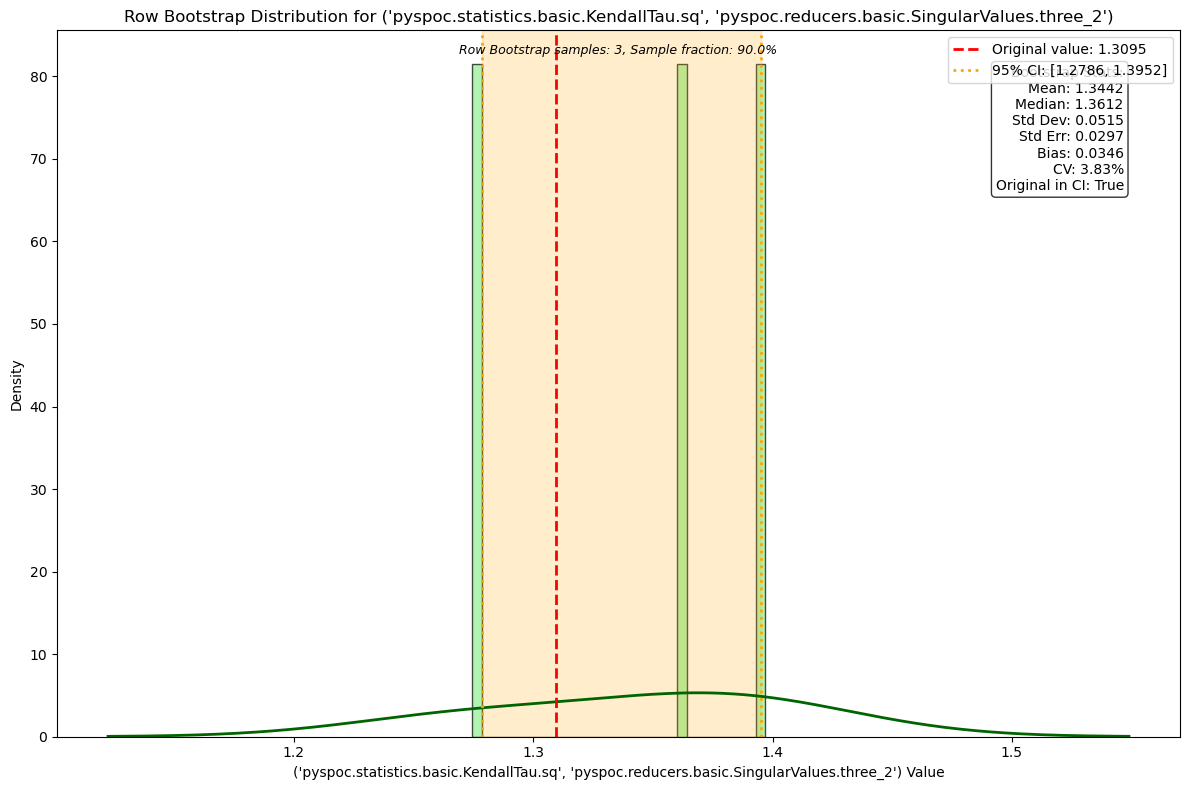

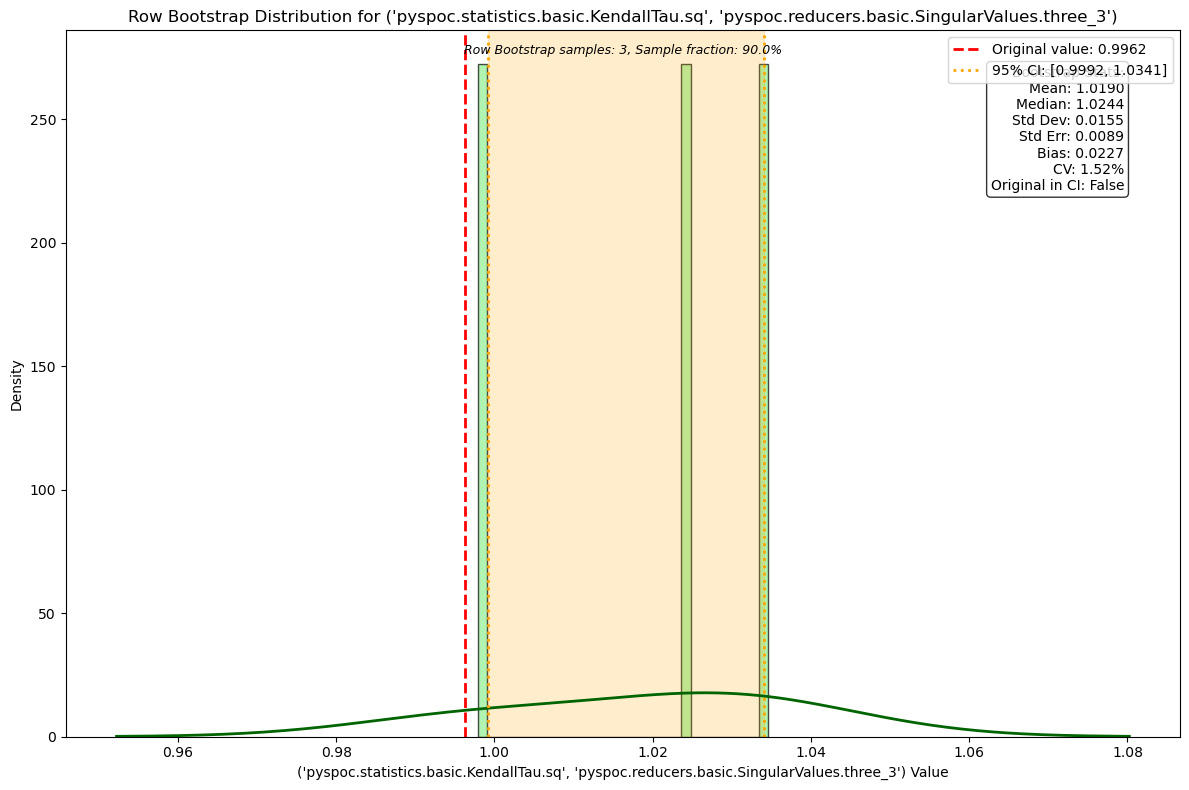

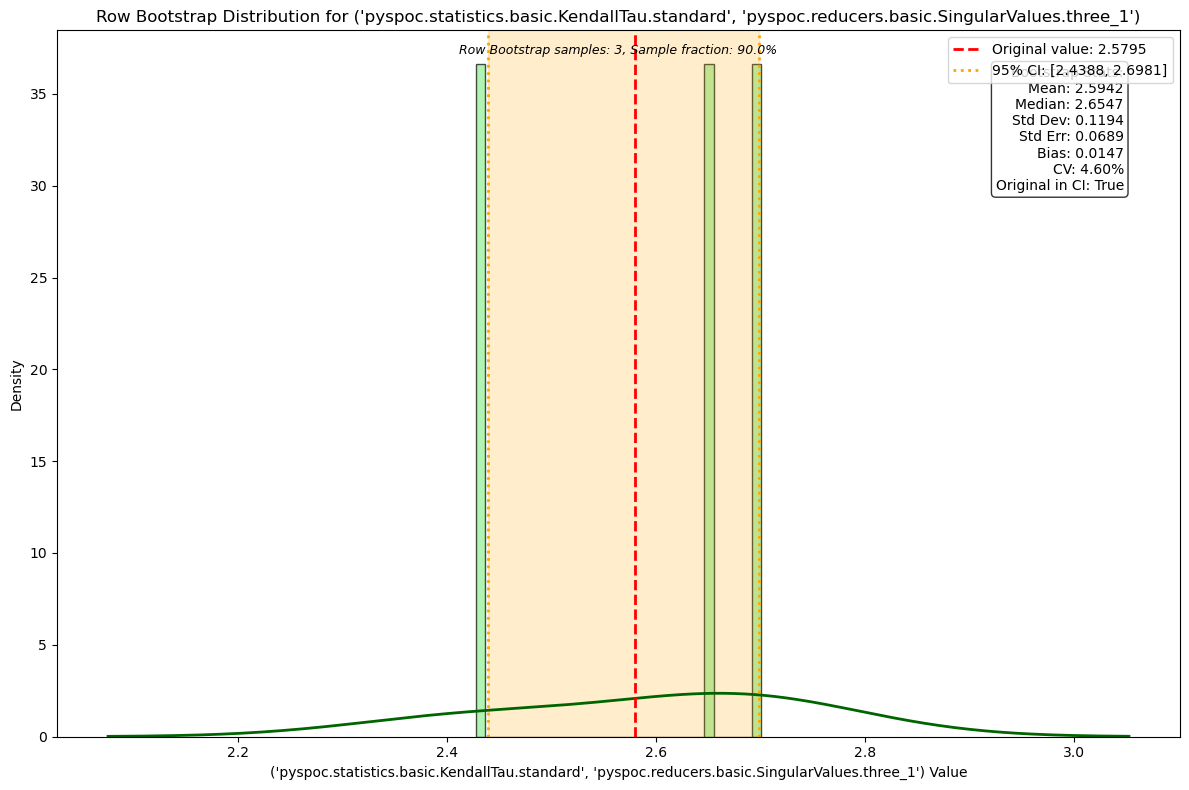

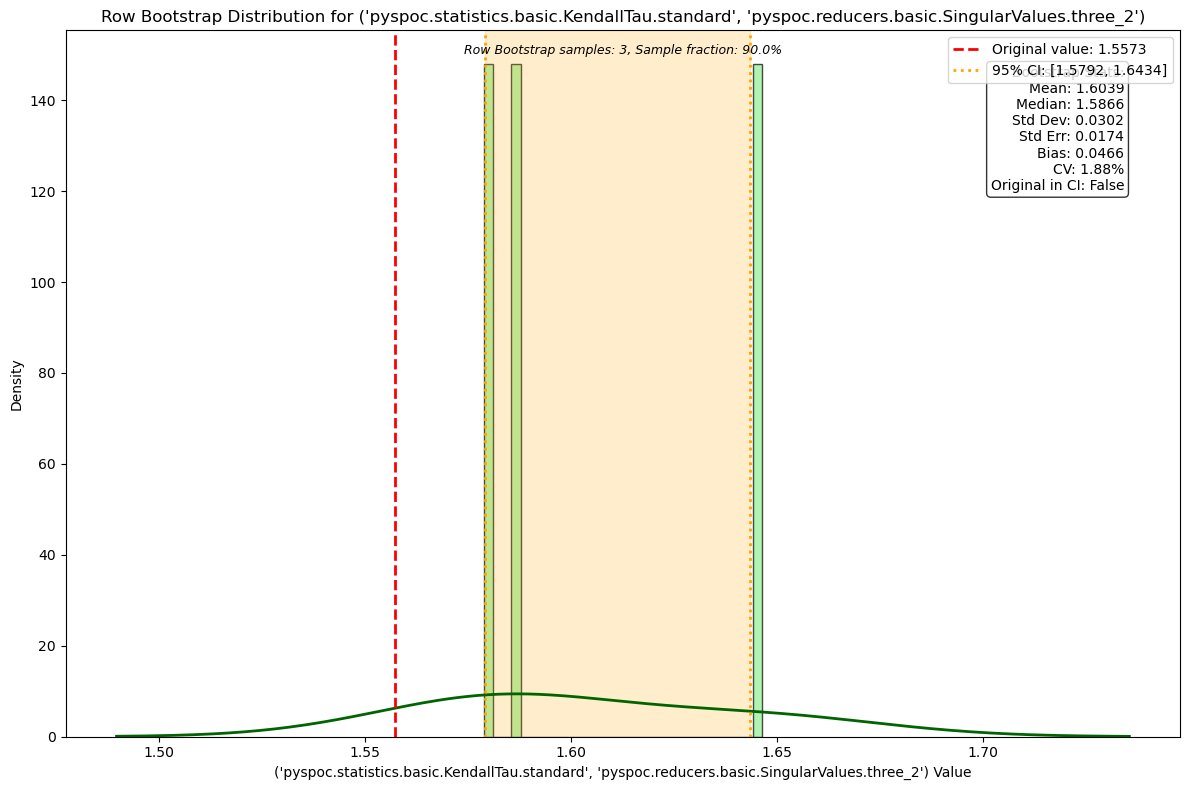

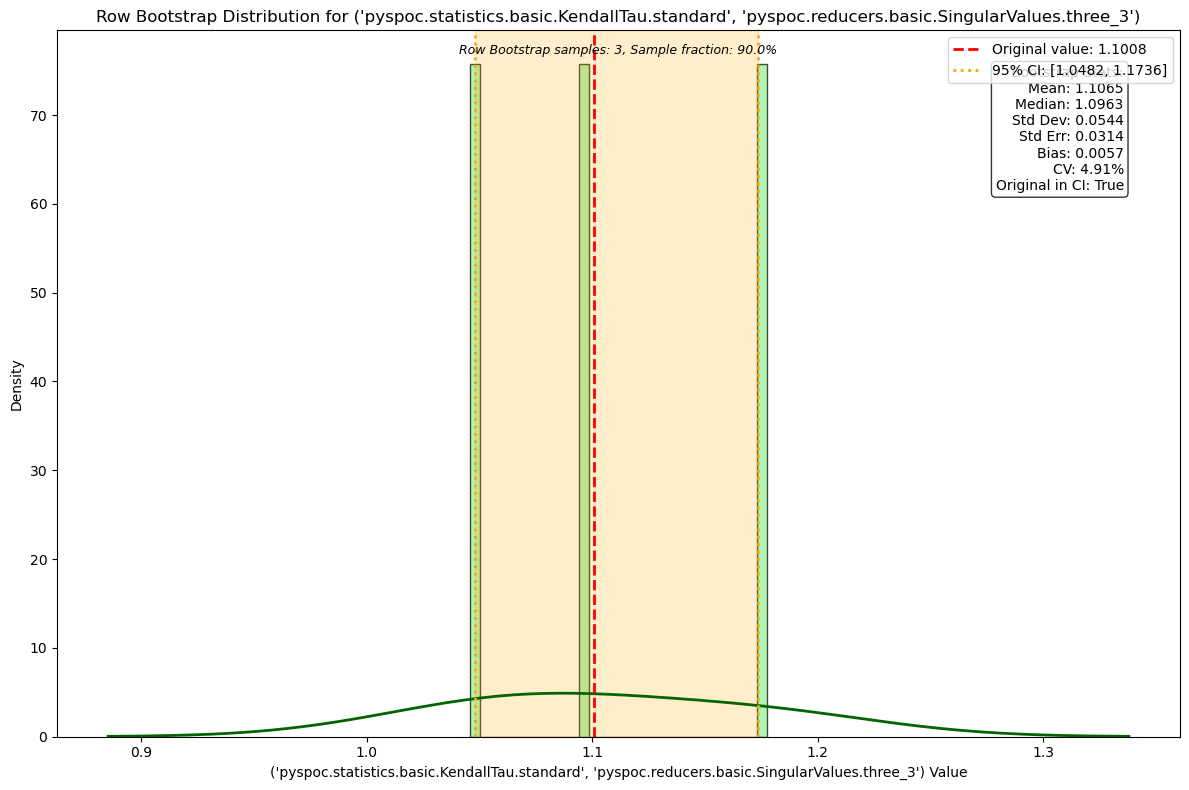

In [26]:
plot_all_bootstrap_distributions(bootstrap_results)

In [27]:
def bootstrap_sample_columns(df: pd.DataFrame, sample_fraction: float = 0.9, random_seed: Optional[int] = None) -> pd.DataFrame:
    """
    Create a bootstrap sample from the dataframe by sampling a fraction of rows (columns in original data) with replacement.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    n_samples = int(len(df.index) * sample_fraction)
    sampled_indices = np.random.choice(df.index, size=n_samples, replace=True)
    bootstrap_df = df.loc[sampled_indices, :].copy()
    return bootstrap_df

def pyspi_calc_bootstrap_columns(name: str,config_name: str, yaml,skip: int = 1, normalize: Optional[str] = None,
                        sample_fraction: float = 0.9, random_seed: Optional[int] = None):
    """
    Calculate covariance and other statistics from a CSV file using bootstrap sampling.

    Parameters:
    -----------
    name : str
        CSV filename
    config_name: str
        Name of the configuration file
    yaml : YAML string for configuration
    skip : int, optional
        Number of columns to skip (default: 1)
    normalize : Optional[str], optional
        Method to normalize data (default: None)
    sample_fraction : float, optional
        Fraction of rows to sample for bootstrap (default: 0.9)
    random_seed : Optional[int], optional
        Seed for reproducible sampling (default: None)

    Returns:
    --------
    Dictionary of calculated statistics
    """
    # Load data with optional normalization
    df = load_data(filename=name, skip=skip)

    # Create bootstrap sample
    bootstrap_df = bootstrap_sample_columns(df, sample_fraction=sample_fraction, random_seed=random_seed)
    if normalize is not None:
        bootstrap_df = normalize_data(bootstrap_df, method=normalize)
    bootstrap_df = bootstrap_df.transpose()  # Transpose to match expected format
    # Use Calculator class to compute the statistics
    cfg = Config.from_yaml(config_name, yaml)
    calc = Calculator(bootstrap_df, normalise=False)
    calc.compute(cfg)
    return calc.results


def bootstrap_test_columns(
    filename: str,
    config_name,
    yaml,
    calc,
    n_bootstrap_columns: int = 1000,
    sample_fraction_columns: float = 0.9,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    save_bootstrap_data: bool = True,
    orig_calc_table: Optional[Dict] = None,  
) -> Dict[str, Dict[str, Dict[str, Any]]]:
    """
    Perform bootstrap sampling test to assess variability of statistics.
    """
    REDUCERS = list(calc.columns.values)
    # Use provided orig_calc_table or compute if not given
    if orig_calc_table is None:
        orig_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize)
    
    orig_results = {
        reducer: orig_calc_table[reducer].values[0] for reducer in REDUCERS
    }
    
    # Store bootstrap values for variance calculation and plotting
    bootstrap_values = {reducer: [] for reducer in REDUCERS}

    # Run bootstrap samples with progress bar
    iter_range = tqdm(range(n_bootstrap_columns), desc="Bootstrap sampling")
    for i in iter_range:
        # Use different random seed for each bootstrap sample
        bootstrap_seed = None if random_seed is None else random_seed + i + 1
        # Get bootstrap sample statistics
        bootstrap_calc_table = pyspi_calc_bootstrap_columns(filename, config_name,yaml,skip=skip, normalize=normalize,
                                                   sample_fraction=sample_fraction_columns, random_seed=bootstrap_seed)

        for reducer_name in REDUCERS:
            try:
                bootstrap_value = bootstrap_calc_table[reducer_name].values[0]
                bootstrap_values[reducer_name].append(bootstrap_value)
            except:
                continue
            
    # Calculate bootstrap statistics and add to results
    
    final_results = {}
    for reducer_name in REDUCERS:
        orig_value = orig_results[reducer_name]
        result = {
            'original_value': orig_value,
            'n_bootstrap': n_bootstrap_columns,
            'sample_fraction': sample_fraction_columns
        }

        if save_bootstrap_data and bootstrap_values[reducer_name]:
            bootstrap_data = bootstrap_values[reducer_name]

            # Calculate confidence intervals (2.5% and 97.5% percentiles for 95% CI)
            ci_lower = np.percentile(bootstrap_data, 2.5)
            ci_upper = np.percentile(bootstrap_data, 97.5)

            result.update({
                'bootstrap_mean': np.mean(bootstrap_data),
                'bootstrap_median': np.median(bootstrap_data),
                'bootstrap_std': np.std(bootstrap_data),
                'bootstrap_variance': np.var(bootstrap_data),
                'bootstrap_std_err': np.std(bootstrap_data) / np.sqrt(len(bootstrap_data)),
                'bootstrap_min': np.min(bootstrap_data),
                'bootstrap_max': np.max(bootstrap_data),
                'bootstrap_ci_lower': ci_lower,
                'bootstrap_ci_upper': ci_upper,
                'bootstrap_distribution': bootstrap_data if save_bootstrap_data else None,
                'original_in_ci': ci_lower <= orig_value <= ci_upper,
                'bias': np.mean(bootstrap_data) - orig_value,
                'coefficient_of_variation': np.std(bootstrap_data) / np.abs(np.mean(bootstrap_data)) * 100 if np.mean(bootstrap_data) != 0 else np.nan
            })

        final_results[reducer_name] = result

    return final_results

def plot_bootstrap_distribution_columns(results: Dict, reducer,
                               figsize: Tuple[int, int] = (10, 6)) -> Figure:
    """
    Plot the distribution of bootstrap test values

    Parameters:
    -----------
    results : Dict
        Dictionary containing bootstrap test results.
    reducer : str
        Name of the reducer
    figsize : Tuple[int, int], optional
        Figure size (width, height), by default (10, 6)

    Returns:
    --------
    Figure
        Matplotlib figure object.
    """
    # Extract data
    result = results[reducer]
    bootstrap_values = result['bootstrap_distribution']
    orig_value = result['original_value']
    ci_lower = result['bootstrap_ci_lower']
    ci_upper = result['bootstrap_ci_upper']

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of bootstrap values
    n, bins, patches = ax.hist(bootstrap_values, bins=30, alpha=0.7, color='lightgreen',
                              edgecolor='black', density=True)

    # Add kernel density
    sns.kdeplot(bootstrap_values, color='darkgreen', ax=ax, linewidth=2)

    # Add vertical line for original value
    ax.axvline(x=orig_value, color='red', linestyle='--', linewidth=2,
              label=f'Original value: {orig_value:.4f}')

    # Add confidence interval lines
    ax.axvline(x=ci_lower, color='orange', linestyle=':', linewidth=2,
              label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
    ax.axvline(x=ci_upper, color='orange', linestyle=':', linewidth=2)

    # Fill confidence interval area
    ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='orange')

    # Add bootstrap statistics
    stats_text = (
        f"Bootstrap Stats:\n"
        f"Mean: {result['bootstrap_mean']:.4f}\n"
        f"Median: {result['bootstrap_median']:.4f}\n"
        f"Std Dev: {result['bootstrap_std']:.4f}\n"
        f"Bias: {result['bias']:.4f}\n"
        f"Std Err: {result['bootstrap_std_err']:.4f}\n"
        f"CV: {result['coefficient_of_variation']:.2f}%\n"
        f"Original in CI: {result['original_in_ci']}"
    )

    # Add the stats text as an annotation
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add labels and title
    ax.set_xlabel(f'{reducer} Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Column Bootstrap Distribution for {reducer}')

    # Add subtitle with sample info
    subtitle = f'Column Bootstrap samples: {result["n_bootstrap"]}, Sample fraction: {result["sample_fraction"]:.1%}'
    ax.text(0.5, 0.98, subtitle, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', horizontalalignment='center', style='italic')

    ax.legend()
    fig.tight_layout()

    return fig


def plot_all_bootstrap_distributions_columns(results: Dict, figsize: Tuple[int, int] = (12, 8)) -> Dict[str, Figure]:
    figures = {}
    for reducer_name, reducer_results in results.items():
        key = str(reducer_name)
        try:
            fig = plot_bootstrap_distribution_columns(results, reducer_name, figsize=figsize)
            figures[key] = fig
        except Exception as e:
            print(f"Error plotting bootstrap {reducer_name}: {e}")
    return figures

In [28]:
def perturbation_test(
    filename: str,
    config_name,
    yaml,
    calc,
    n_perturbations: int = 1000,
    scale_factor: float = 0.1,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    save_perturbation_data: bool = True,
    orig_calc_table: Optional[Dict] = None,
) -> Dict[str, Dict[str, Any]]:
    """
    Perform a perturbation test to assess statistical significance and calculate variance.
    """
    REDUCERS = list(calc.columns.values)
    # Use provided orig_calc_table or compute
    if orig_calc_table is None:
        orig_calc_table = pyspi_calc(filename, config_name, yaml,skip=skip, normalize=normalize)

    orig_results = {
        reducer: orig_calc_table[reducer].values[0] for reducer in REDUCERS
    }
    
    perturb_values = {reducer: [] for reducer in REDUCERS}

    # Run perturbations with progress bar
    iter_range = tqdm(range(n_perturbations), desc="Perturbation sampling")
    for i in iter_range:
        # Use different random seed for each perm
        perturb_seed = None if random_seed is None else random_seed + i + 1
        # Get shuffled data statistics
        perturb_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize, perturb=True, scale_factor=scale_factor,random_seed=perturb_seed)

        for reducer in REDUCERS:
            perturb_value = perturb_calc_table[reducer].values[0]
            # Append the value to the list
            perturb_values[reducer].append(perturb_value)

    # Calculate p-values, variances, and add to results
    # Create the DataFrame of perturbation results AFTER collecting all values
    # The index length should match the number of perturbations
    perturb_data = pd.DataFrame(perturb_values)
    # Calculate p-values, variances, and add to results
    final_results = {}
    for reducer in REDUCERS:
        # Access the specific reducer's data from the perm_data DataFrame
        perturb_data_series = perturb_data[reducer]
        orig_value = orig_results[reducer]
        n = len(perturb_data_series) # Use the length of the collected data

        # Calculate permutation percentile for p-value
        lower_tail = np.sum(perturb_data_series < orig_value) / n
        upper_tail = np.sum(perturb_data_series > orig_value) / n
        perturbation_percentile = min(lower_tail, upper_tail)
        p_value = perturbation_percentile * 2 # Multiply by 2 for a two-tailed test

        result = {'value': orig_value,
              'p_value': p_value}

        # Update results with permutation statistics
        result.update({
            'perturbation_mean': np.mean(perturb_data_series),
            'perturbation_median': np.median(perturb_data_series),
            'perturbation_std': np.std(perturb_data_series),
            'perturbation_variance': np.var(perturb_data_series),
            'perturbation_std_err': np.std(perturb_data_series) / np.sqrt(n),
            'perturbation_min': np.min(perturb_data_series),
            'perturbation_max': np.max(perturb_data_series),
            'perturbation_distribution': perturb_data_series.tolist() if save_perturbation_data else None, # Store as list if needed
            'perturbation_percentile_rank': perturbation_percentile
        })

        final_results[reducer] = result
    return final_results


def plot_perturbation_distribution(results: Dict, reducer: str,
                                 figsize: Tuple[int, int] = (10, 6)) -> Figure:
    """
    Plot the distribution of perturbation test values

    Parameters:
    -----------
    results : Dict
        Dictionary containing perturbation test results.
    reducer : str
        Name of the reducer
    figsize : Tuple[int, int], optional
        Figure size (width, height), by default (10, 6)

    Returns:
    --------
    Figure
        Matplotlib figure object.
    """

    # Extract data
    result = results[reducer]
    perturb_values = result['perturbation_distribution']
    orig_value = result['value']
    p_value = result['p_value']

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of permutation values
    n, bins, patches = ax.hist(perturb_values, bins=30, alpha=0.7, color='skyblue',
                              edgecolor='black', density=True)

    # Add kernel density estimate
    sns.kdeplot(perturb_values, color='navy', ax=ax, linewidth=2)

    # Add vertical line for original value
    ax.axvline(x=orig_value, color='red', linestyle='--', linewidth=2,
              label=f'Original value: {orig_value:.4f}')

    # Add permutation statistics
    stats_text = (
        f"Perturbation Stats:\n"
        f"Mean: {result['perturbation_mean']:.4f}\n"
        f"Median: {result['perturbation_median']:.4f}\n"
        f"Std Dev: {result['perturbation_std']:.4f}\n"
        f"Std Err: {result['perturbation_std_err']:.4f}\n"
        f"p-value: {p_value:.4f}"
    )

    # Add the stats text as an annotation
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add labels and title
    ax.set_xlabel(f'{reducer} Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Perturbation Distribution for {reducer}')

    ax.legend()
    fig.tight_layout()

    return fig


def plot_all_perturbation_distributions(results: Dict, figsize: Tuple[int, int] = (12, 8)) -> Dict[str, Figure]:
    figures = {}
    for reducer_name, reducer_results in results.items():
        # Convert reducer_name to string for safe dict key
        key = str(reducer_name)
        if (isinstance(reducer_results, dict) and
            'perturbation_distribution' in reducer_results and
            'value' in reducer_results):
            try:
                fig = plot_perturbation_distribution(results, reducer_name, figsize=figsize)
                figures[key] = fig
            except Exception as e:
                print(f"Error plotting {reducer_name}: {e}")
    return figures


In [29]:
def perturbation_test(
    filename: str,
    config_name,
    yaml,
    calc,
    n_perturbations: int = 1000,
    scale_factor: float = 0.1,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    save_perturbation_data: bool = True,
    orig_calc_table: Optional[Dict] = None,
) -> Dict[str, Dict[str, Any]]:
    """
    Perform a perturbation test to assess statistical significance and calculate variance.
    Now also computes a 90% confidence interval for each reducer.
    """
    REDUCERS = list(calc.columns.values)
    # Use provided orig_calc_table or compute
    if orig_calc_table is None:
        orig_calc_table = pyspi_calc(filename, config_name, yaml,skip=skip, normalize=normalize)

    orig_results = {
        reducer: orig_calc_table[reducer].values[0] for reducer in REDUCERS
    }
    
    perturb_values = {reducer: [] for reducer in REDUCERS}

    # Run perturbations with progress bar
    iter_range = tqdm(range(n_perturbations), desc="Perturbation sampling")
    for i in iter_range:
        # Use different random seed for each perm
        perturb_seed = None if random_seed is None else random_seed + i + 1
        # Get shuffled data statistics
        perturb_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize, perturb=True, scale_factor=scale_factor,random_seed=perturb_seed)

        for reducer in REDUCERS:
            perturb_value = perturb_calc_table[reducer].values[0]
            # Append the value to the list
            perturb_values[reducer].append(perturb_value)

    # Calculate p-values, variances, and add to results
    # Create the DataFrame of perturbation results AFTER collecting all values
    # The index length should match the number of perturbations
    perturb_data = pd.DataFrame(perturb_values)
    # Calculate p-values, variances, and add to results
    final_results = {}
    for reducer in REDUCERS:
        # Access the specific reducer's data from the perm_data DataFrame
        perturb_data_series = perturb_data[reducer]
        orig_value = orig_results[reducer]
        n = len(perturb_data_series) # Use the length of the collected data

        # Calculate permutation percentile for p-value
        lower_tail = np.sum(perturb_data_series < orig_value) / n
        upper_tail = np.sum(perturb_data_series > orig_value) / n
        perturbation_percentile = min(lower_tail, upper_tail)
        p_value = perturbation_percentile * 2 # Multiply by 2 for a two-tailed test

        # Calculate 90% confidence interval (5th and 95th percentiles)
        ci_lower = np.percentile(perturb_data_series, 5)
        ci_upper = np.percentile(perturb_data_series, 95)

        result = {'value': orig_value,
              'p_value': p_value}

        # Update results with permutation statistics and CI
        result.update({
            'perturbation_mean': np.mean(perturb_data_series),
            'perturbation_median': np.median(perturb_data_series),
            'perturbation_std': np.std(perturb_data_series),
            'perturbation_variance': np.var(perturb_data_series),
            'perturbation_std_err': np.std(perturb_data_series) / np.sqrt(n),
            'perturbation_min': np.min(perturb_data_series),
            'perturbation_max': np.max(perturb_data_series),
            'perturbation_distribution': perturb_data_series.tolist() if save_perturbation_data else None, # Store as list if needed
            'perturbation_percentile_rank': perturbation_percentile,
            'perturbation_ci_lower': ci_lower,
            'perturbation_ci_upper': ci_upper,
            'original_in_ci': ci_lower <= orig_value <= ci_upper
        })

        final_results[reducer] = result
    return final_results


def plot_perturbation_distribution(results: Dict, reducer: str,
                                 figsize: Tuple[int, int] = (10, 6)) -> Figure:
    """
    Plot the distribution of perturbation test values, including a 90% confidence interval.
    """
    # Extract data
    result = results[reducer]
    perturb_values = result['perturbation_distribution']
    orig_value = result['value']
    p_value = result['p_value']
    ci_lower = result.get('perturbation_ci_lower', None)
    ci_upper = result.get('perturbation_ci_upper', None)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot histogram of permutation values
    n, bins, patches = ax.hist(perturb_values, bins=30, alpha=0.7, color='skyblue',
                              edgecolor='black', density=True)

    # Add kernel density estimate
    sns.kdeplot(perturb_values, color='navy', ax=ax, linewidth=2)

    # Add vertical line for original value
    ax.axvline(x=orig_value, color='red', linestyle='--', linewidth=2,
              label=f'Original value: {orig_value:.4f}')

    # Add confidence interval lines if available
    if ci_lower is not None and ci_upper is not None:
        ax.axvline(x=ci_lower, color='orange', linestyle=':', linewidth=2,
                  label=f'90% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
        ax.axvline(x=ci_upper, color='orange', linestyle=':', linewidth=2)
        ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='orange')

    # Add permutation statistics
    stats_text = (
        f"Perturbation Stats:\n"
        f"Mean: {result['perturbation_mean']:.4f}\n"
        f"Median: {result['perturbation_median']:.4f}\n"
        f"Std Dev: {result['perturbation_std']:.4f}\n"
        f"Std Err: {result['perturbation_std_err']:.4f}\n"
        f"p-value: {p_value:.4f}\n"
        f"90% CI: [{ci_lower:.4f}, {ci_upper:.4f}]\n"
        f"Original in CI: {result.get('original_in_ci', False)}"
    )

    # Add the stats text as an annotation
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add labels and title
    ax.set_xlabel(f'{reducer} Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Perturbation Distribution for {reducer}')

    ax.legend()
    fig.tight_layout()

    return fig


def plot_all_perturbation_distributions(results: Dict, figsize: Tuple[int, int] = (12, 8)) -> Dict[str, Figure]:
    figures = {}
    for reducer_name, reducer_results in results.items():
        # Convert reducer_name to string for safe dict key
        key = str(reducer_name)
        if (isinstance(reducer_results, dict) and
            'perturbation_distribution' in reducer_results and
            'value' in reducer_results):
            try:
                fig = plot_perturbation_distribution(results, reducer_name, figsize=figsize)
                figures[key] = fig
            except Exception as e:
                print(f"Error plotting {reducer_name}: {e}")
    return figures

#

Perturbation sampling:   0%|          | 0/5 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.81it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 237.98it/s]



Calculation complete. Time taken: 0.0837s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 33.43it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 220.00it/s]



Calculation complete. Time taken: 0.1074s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 48.21it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 244.82it/s]



Calculation complete. Time taken: 0.0766s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 48.83it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 218.69it/s]



Calculation complete. Time taken: 0.0762s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.41it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 162.90it/s]



Calculation complete. Time taken: 0.0979s


{"('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_1')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_2')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.SingularValues.three_3')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.scaled')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.non-scaled')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_1')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_2')": <Figure size 1200x800 with 1 Axes>,
 "('pyspoc.statistics.basic.KendallTau.sq', 'pyspoc.reducers.basic.SingularValues.three_3

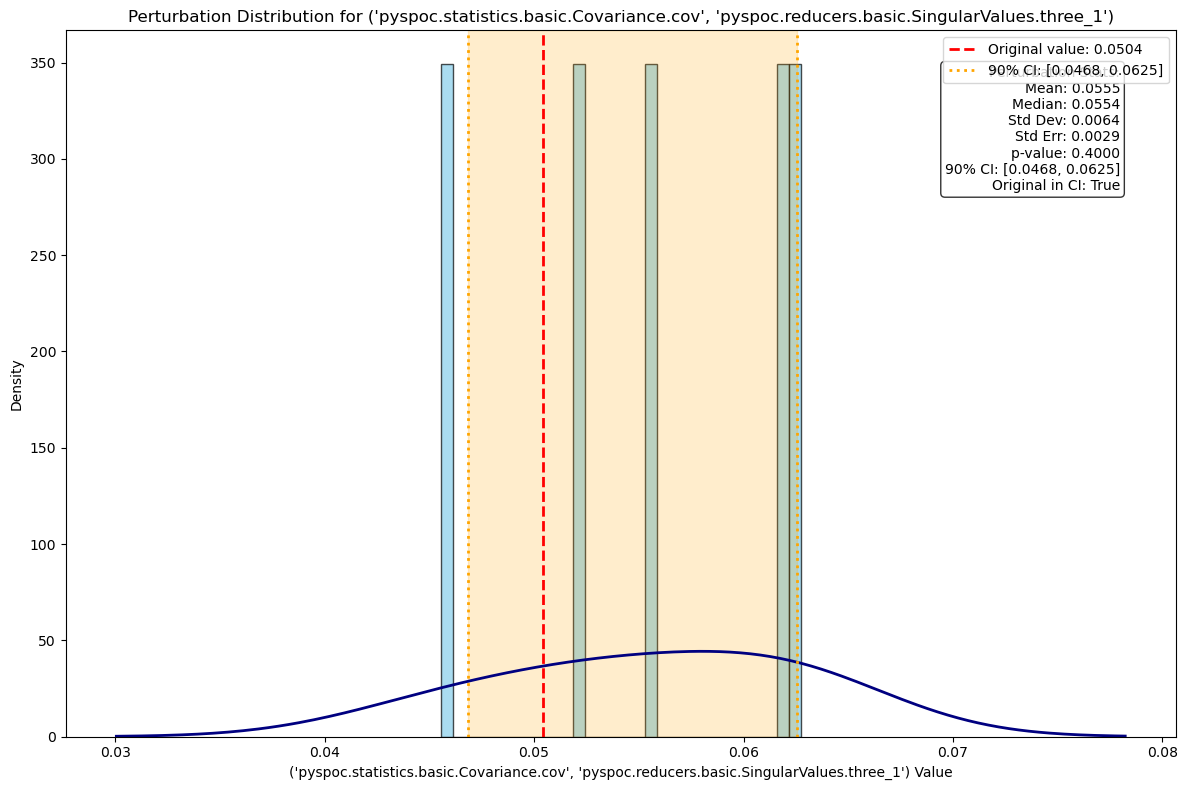

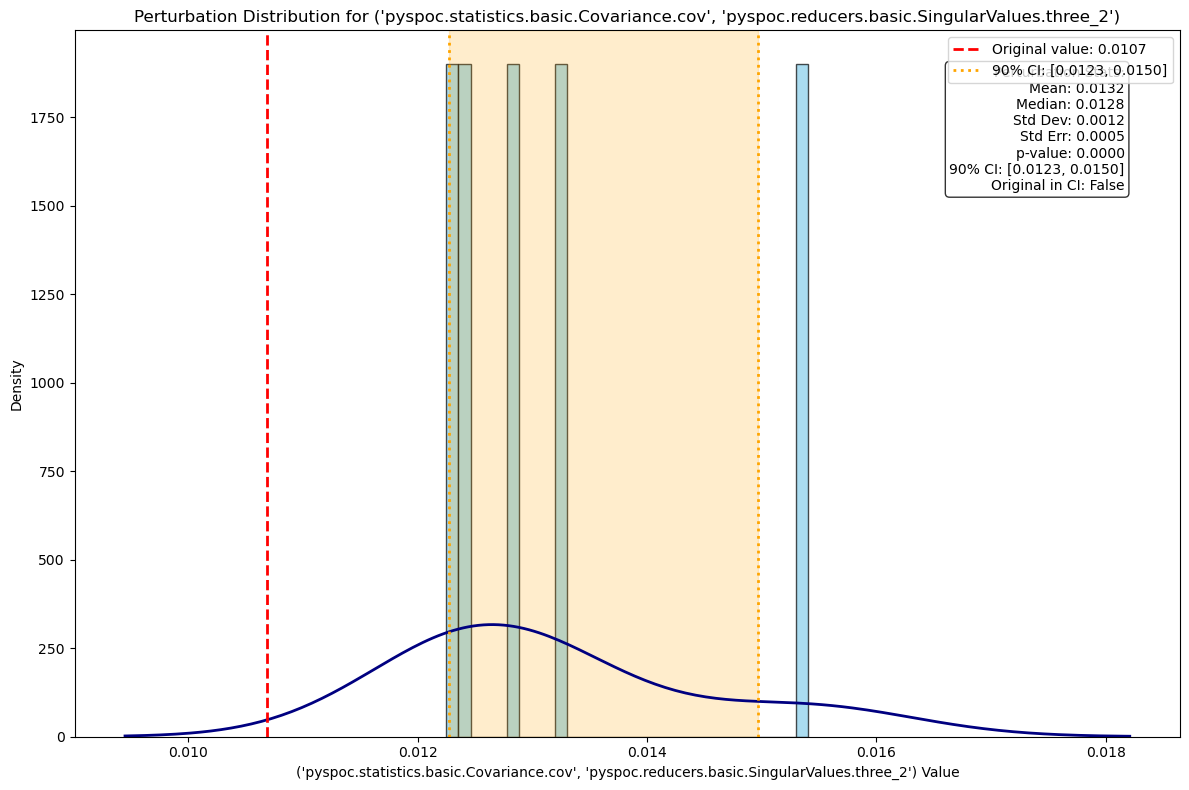

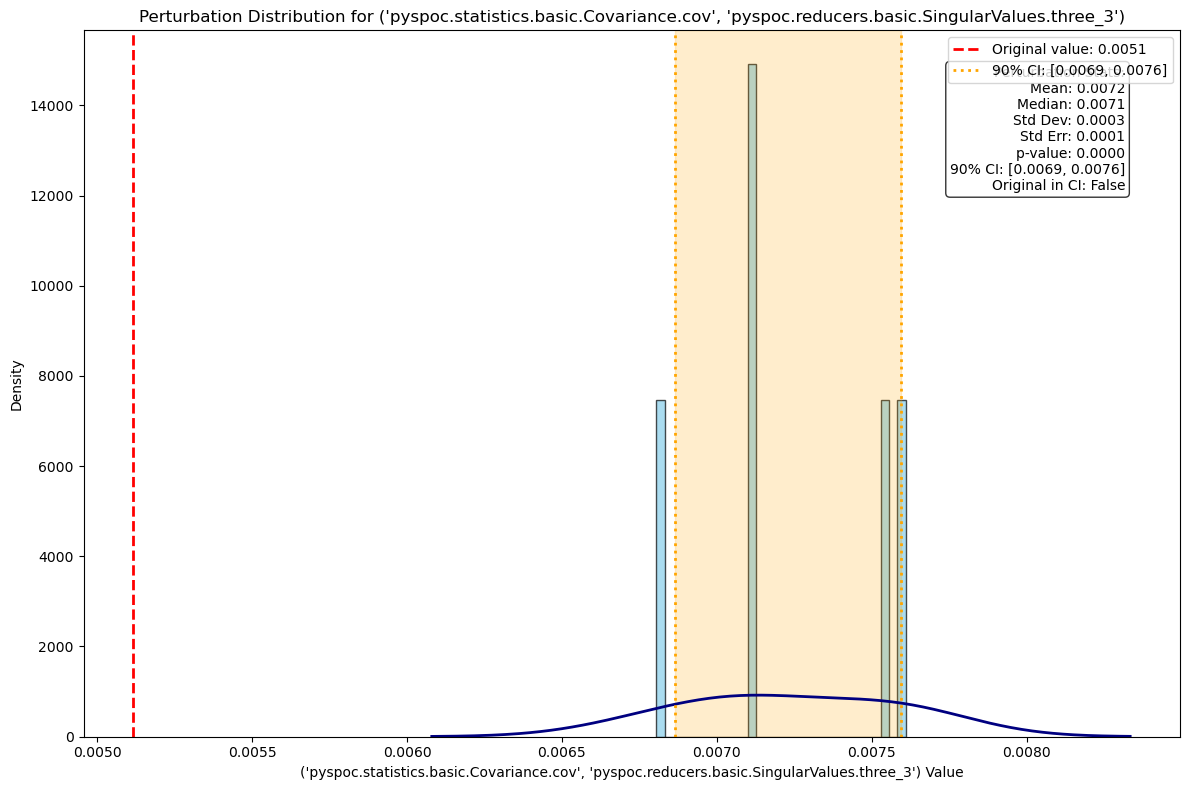

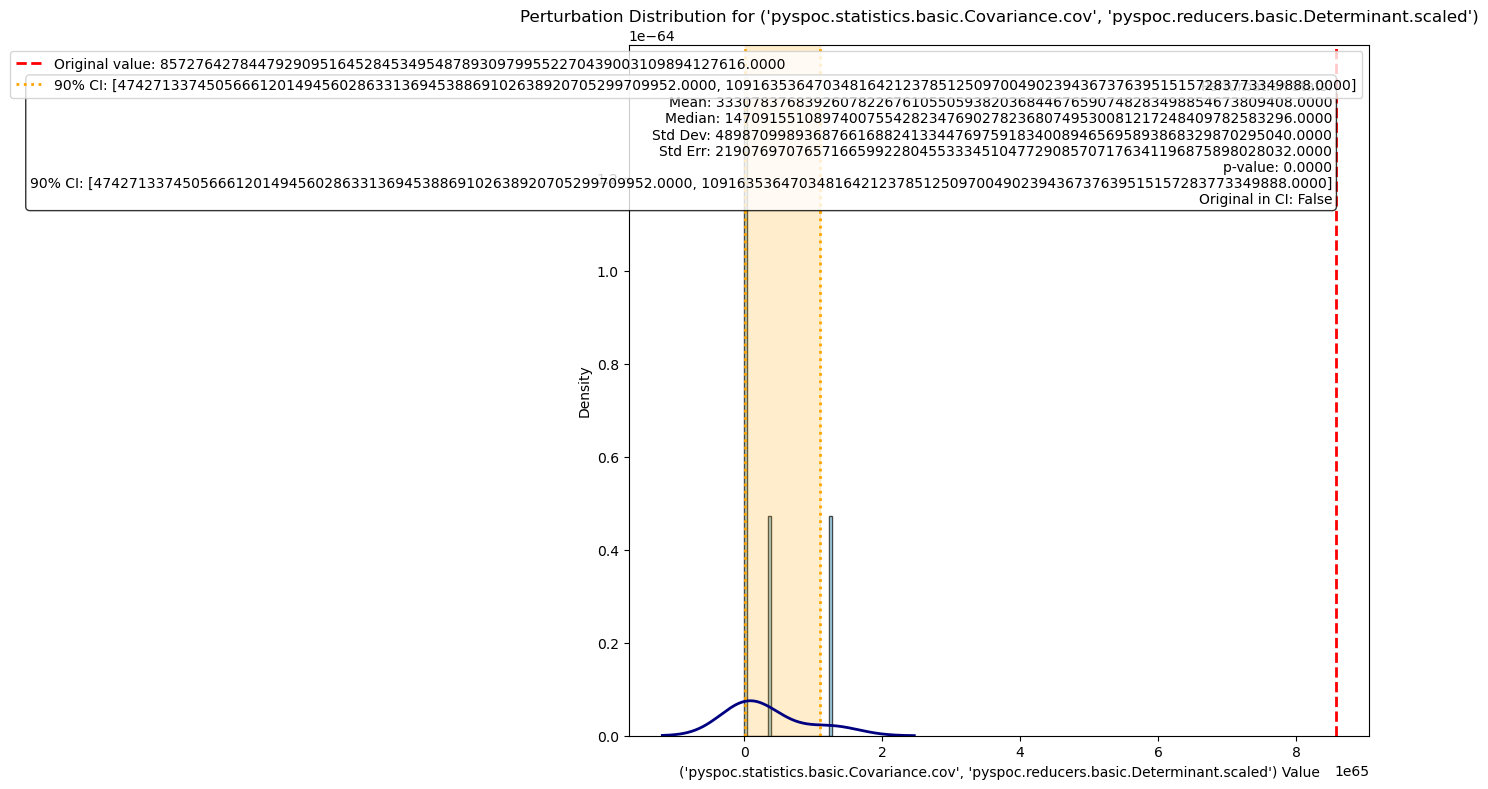

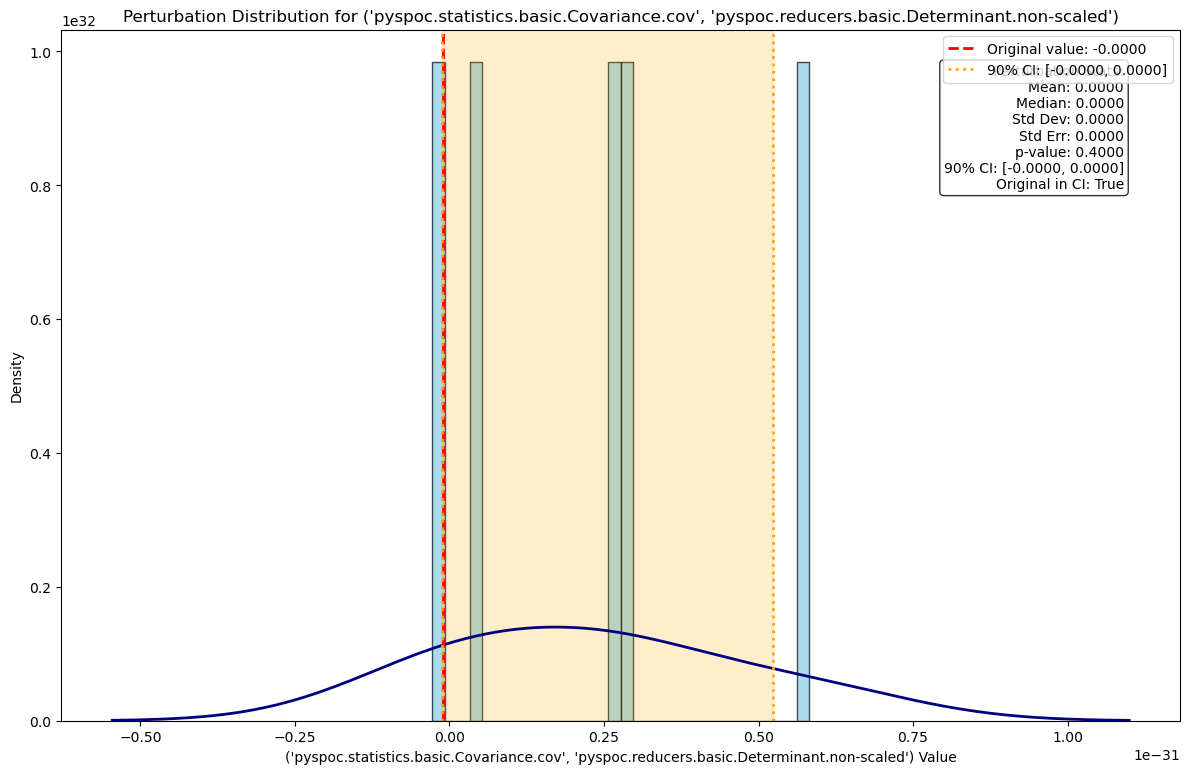

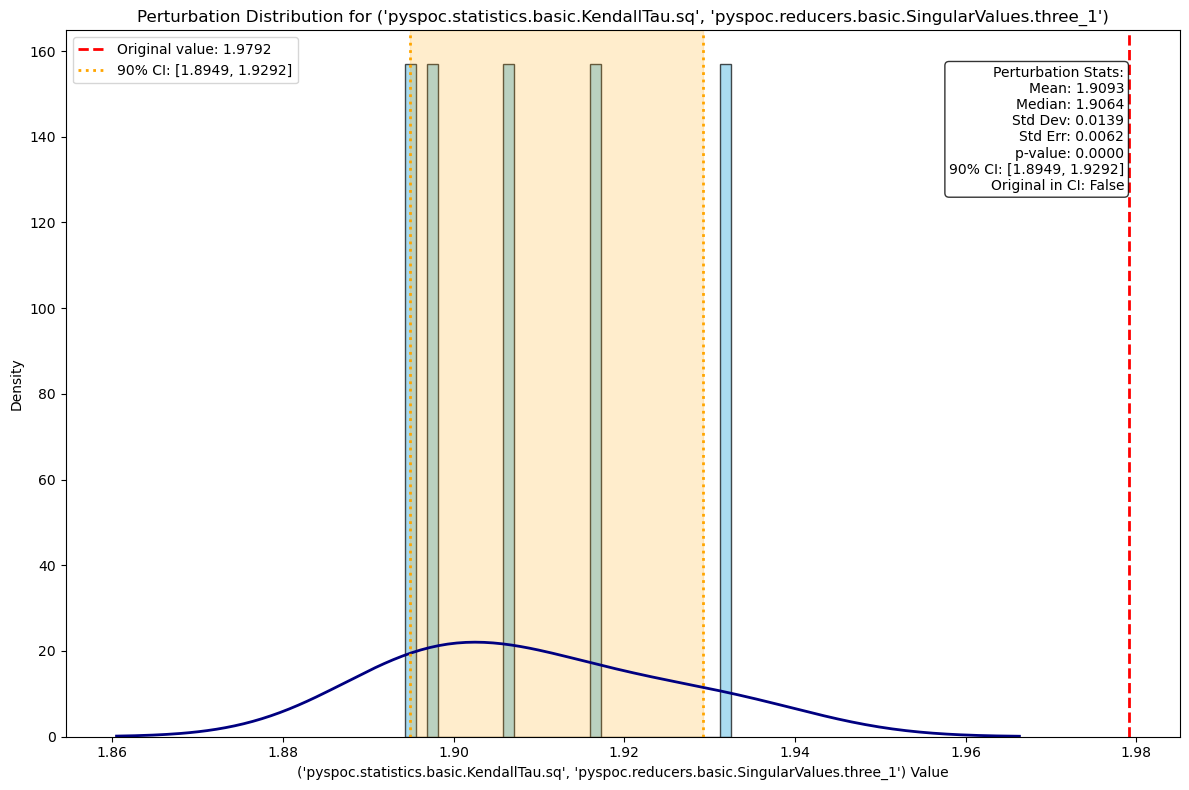

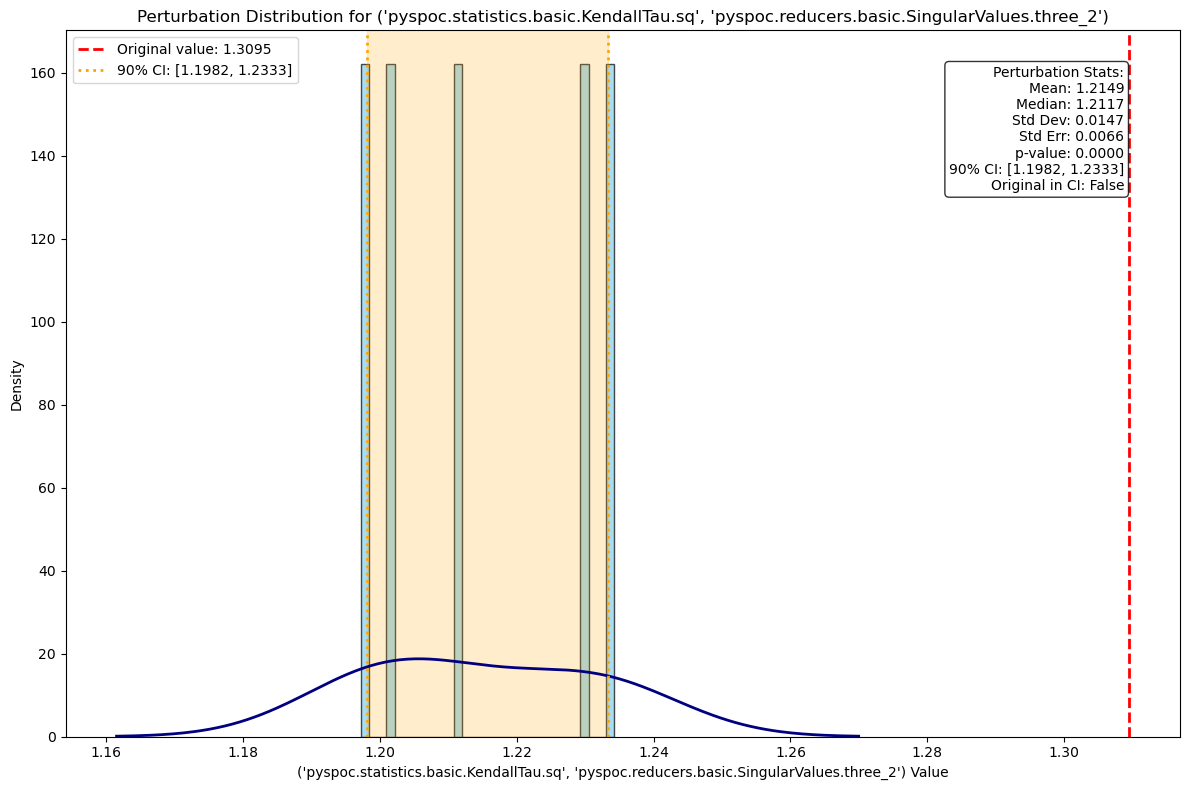

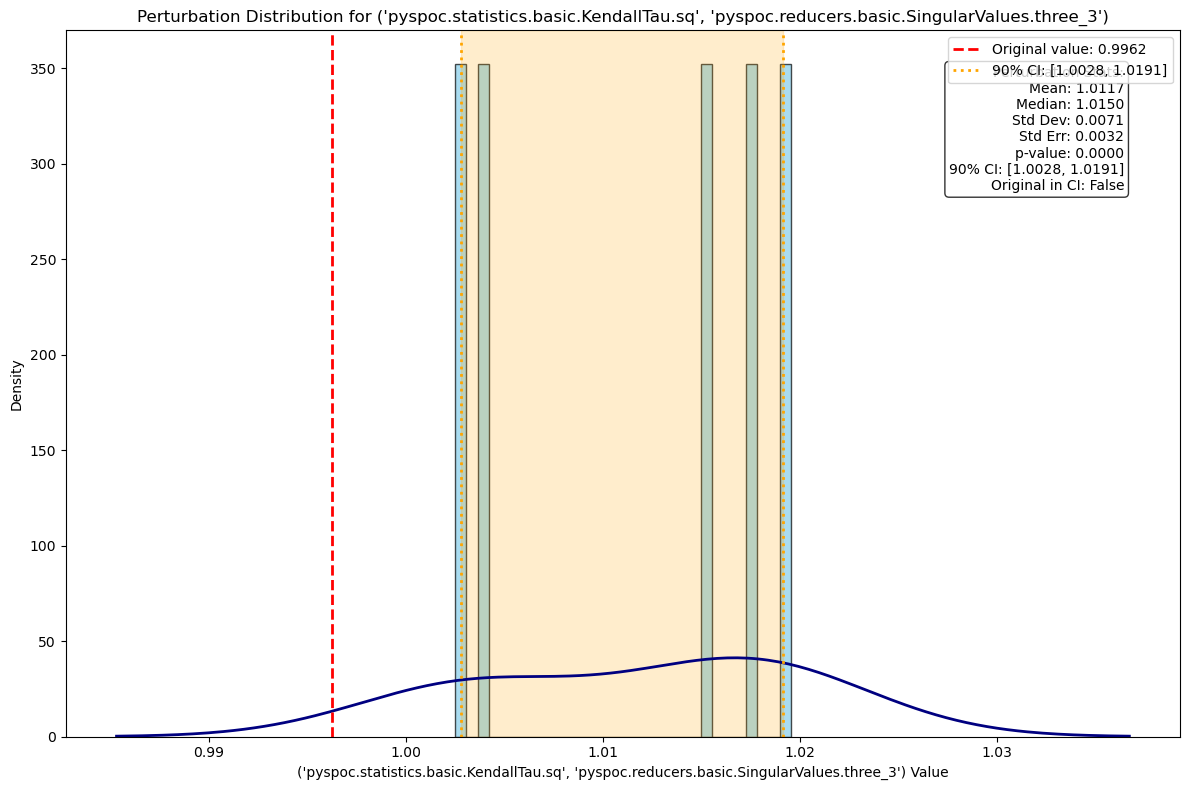

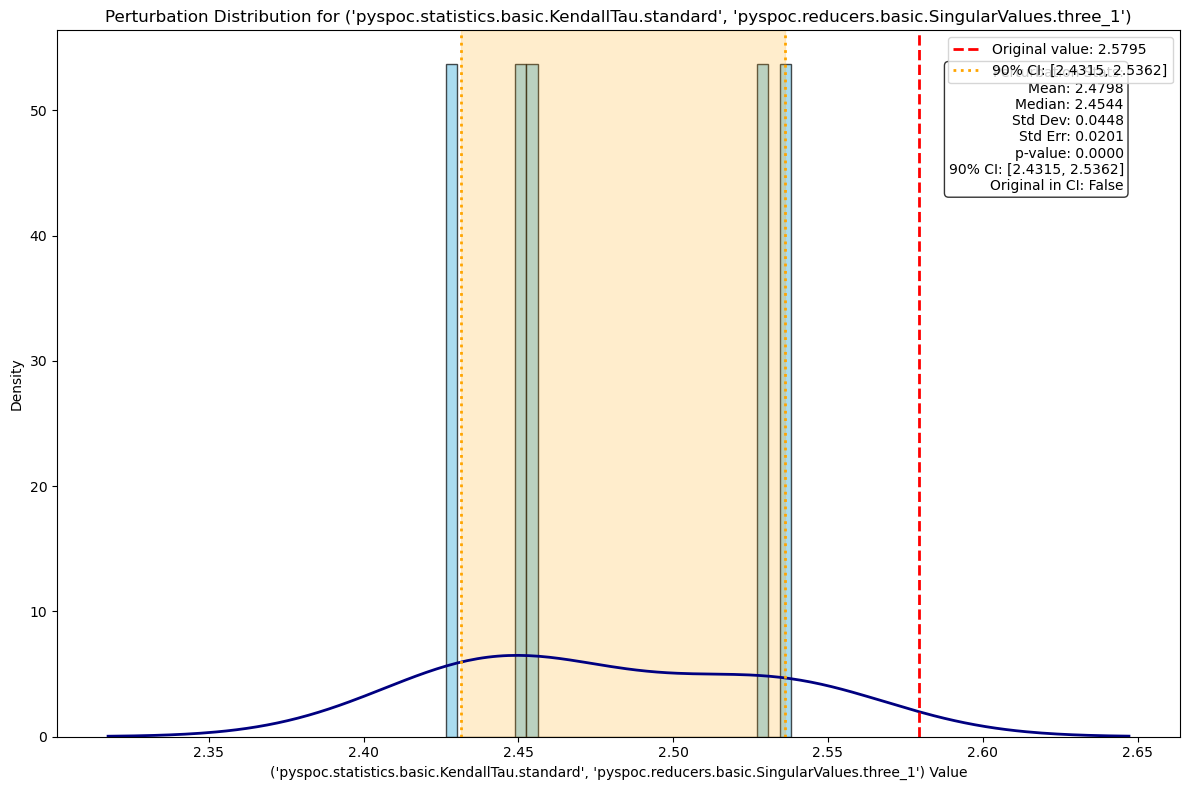

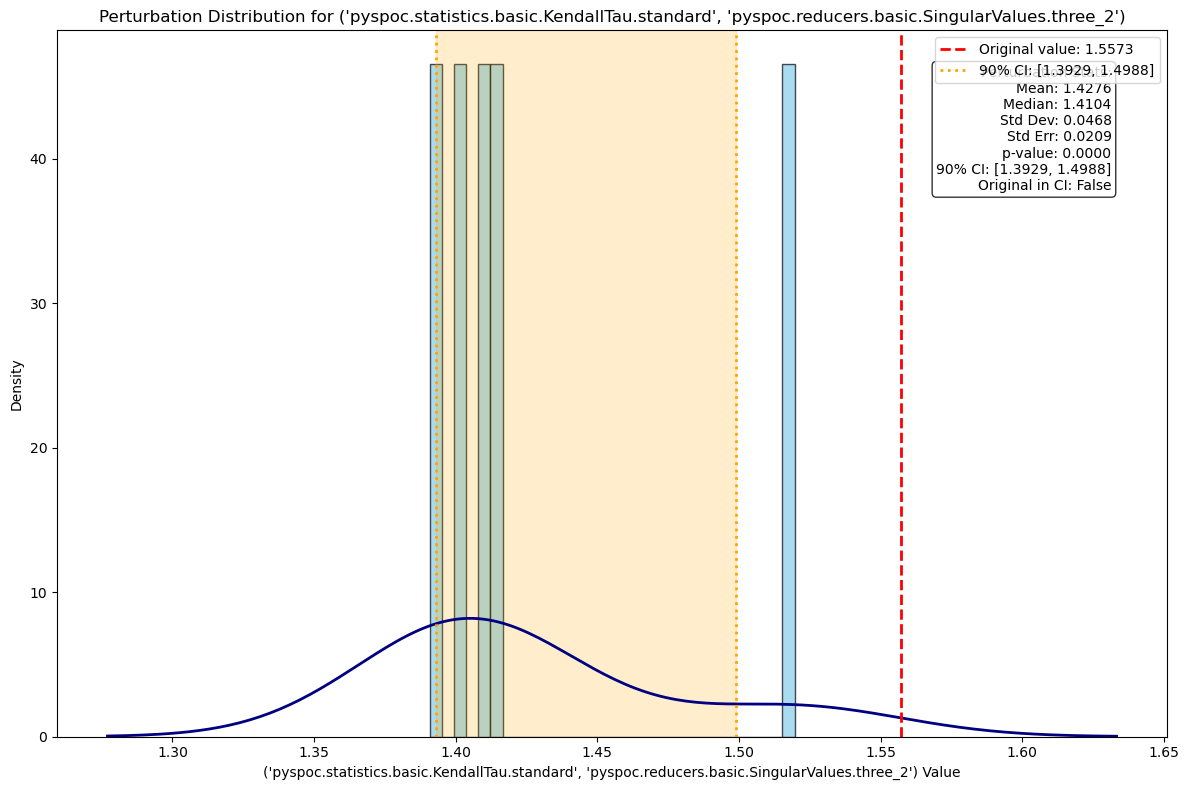

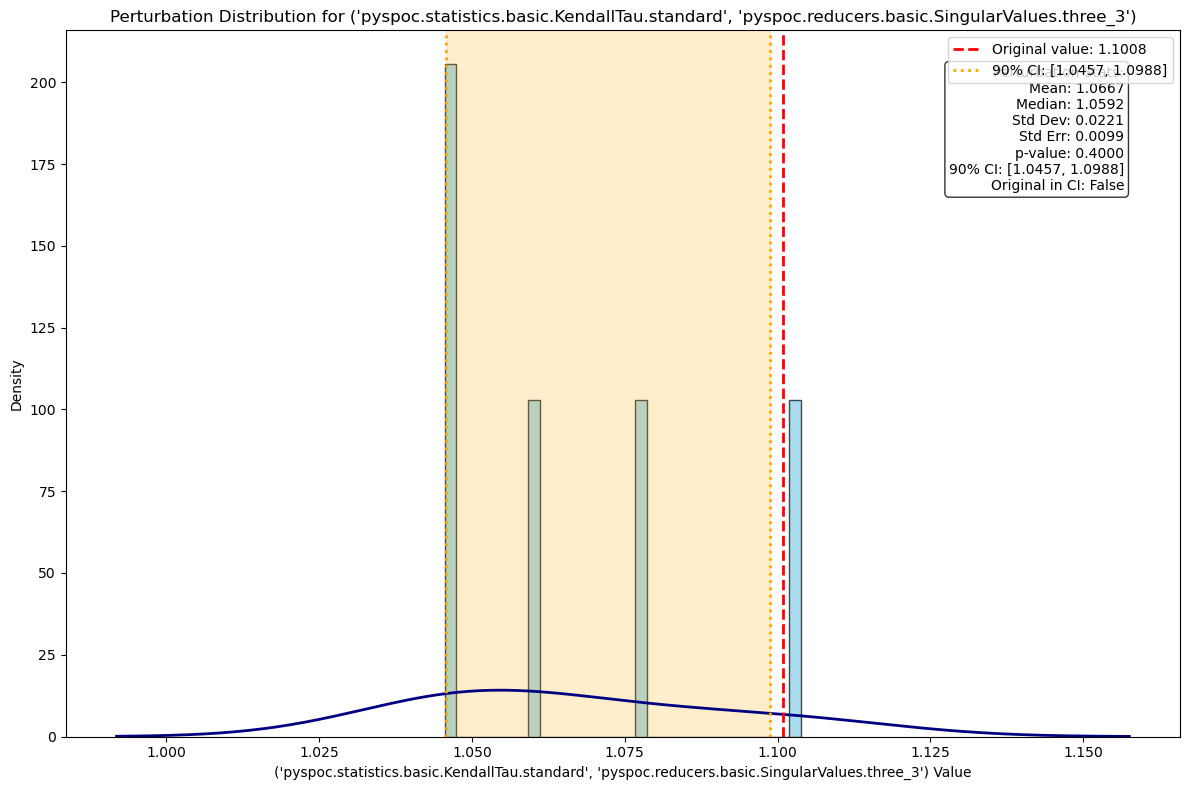

In [30]:

perturb = perturbation_test(
    "unemployment_rate_by_age_groups.csv",
    "test_config_yml",
    yaml_str_stat_reduce,
    orig_calc_table,
    n_perturbations=5,
    skip=5,
    normalize=normalize,
    random_seed=random_seed,
    save_perturbation_data=True,
    orig_calc_table=orig_calc_table
)
plot_all_perturbation_distributions(perturb)

In [31]:
def run_permutation_analysis(
    filename: str,
    config_name,
    yaml,
    n_permutations: int = 1000,
    n_bootstrap_row: int = 1000,
    n_bootstrap_col: int = 1000,
    n_perturbations: int = 1000,
    scale_factor: float = 0.1,
    bootstrap_sample_fraction_row: float = 0.9,
    bootstrap_sample_fraction_col: float = 0.9,
    skip: int = 1,
    normalize: Optional[str] = None,
    random_seed: Optional[int] = None,
    pdf_output: str = None
) -> Dict:
    """
    Run a comprehensive permutation and bootstrap analysis with combined visualizations and detailed summaries.
    Now uses leave-one-column-out and random column bootstrap for column bootstrap.
    """
    print(f"{n_permutations} permutations, {n_bootstrap_row} row bootstrap samples, {n_bootstrap_col} column bootstrap samples, {n_perturbations} perturbations")

    # Calculate orig_calc_table once
    orig_calc_table = pyspi_calc(filename, config_name,yaml,skip=skip, normalize=normalize)

    # Permutation test
    print("Permutation analysis:")
    permutation_results = permutation_test(
        filename,
        config_name,
        yaml,
        orig_calc_table,
        n_permutations=n_permutations,
        skip=skip,
        normalize=normalize,
        random_seed=random_seed,
        save_permutation_data=True,
        orig_calc_table=orig_calc_table,
    )

    # Row bootstrap test
    print("Row bootstrap analysis:")
    bootstrap_results = bootstrap_test(
        filename,
        config_name,
        yaml,
        orig_calc_table,
        n_bootstrap=n_bootstrap_row,
        sample_fraction=bootstrap_sample_fraction_row,
        skip=skip,
        normalize=normalize,
        random_seed=random_seed,
        save_bootstrap_data=True,
        orig_calc_table=orig_calc_table,
    )

    # # Column bootstrap test (leave-one-column-out)
    # print("Column bootstrap analysis (jackknife):")
    # column_bootstrap_results_jackknife = bootstrap_test_columns_jackknife(
    #     filename=filename,
    #     statistic_names=statistic_names,
    #     reducer_names=all_reducers,
    #     skip=skip,
    #     normalize=normalize,
    #     save_bootstrap_data=True,
    #     orig_calc_table=orig_calc_table,
    # )

    # Column bootstrap test (random columns)
    print("Column bootstrap analysis (random columns):")
    column_bootstrap_results_random = bootstrap_test_columns(
        filename,
        config_name,
        yaml,
        orig_calc_table,
        n_bootstrap_columns=n_bootstrap_col,
        sample_fraction_columns=bootstrap_sample_fraction_col,
        skip=skip,
        normalize=normalize,
        random_seed=random_seed,
        save_bootstrap_data=True,
        orig_calc_table=orig_calc_table,
    )


    # Perturbation test
    print("Perturbation analysis:")
    perturbation_results = perturbation_test(
        filename,
        config_name,
        yaml,
        orig_calc_table,
        n_perturbations=n_perturbations,
        scale_factor=scale_factor,
        skip=skip,
        normalize=normalize,
        random_seed=random_seed,
        save_perturbation_data=True,
        orig_calc_table=orig_calc_table,
    )

    # Combine results
    results = {
        'permutation_results': permutation_results,
        'row_bootstrap_results': bootstrap_results,
        # 'column_bootstrap_results_jackknife': column_bootstrap_results_jackknife,
        'column_bootstrap_results_random': column_bootstrap_results_random,
        'perturbation_results': perturbation_results,
        'metadata': {
            'filename': filename,
            'n_permutations': n_permutations,
            'n_bootstrap_row': n_bootstrap_row,
            'n_bootstrap_col': n_bootstrap_col,
            'n_perturbations': n_perturbations,
            'scale_factor': scale_factor,
            'bootstrap_sample_fraction_row': bootstrap_sample_fraction_row,
            'bootstrap_sample_fraction_col': bootstrap_sample_fraction_col,
            'skip': skip,
            'normalize': normalize,
            'random_seed': random_seed
        }
    }

    print("Generating permutation distribution plots...")
    permutation_distribution_plots = plot_all_permutation_distributions(permutation_results)
    print("Generating row bootstrap distribution plots...")
    row_bootstrap_plots = plot_all_bootstrap_distributions(bootstrap_results)
    # print("Generating column bootstrap (jackknife) distribution plots...")
    # column_bootstrap_plots = plot_all_column_bootstrap_distributions(column_bootstrap_results_jackknife, method="Jackknife")
    print("Generating column bootstrap (random) distribution plots...")
    column_bootstrap_random_plots = plot_all_bootstrap_distributions_columns(column_bootstrap_results_random)
    print("Generating perturbation distribution plots...")
    perturbation_distribution_plots = plot_all_perturbation_distributions(perturbation_results)

    results['permutation_distribution_plots'] = permutation_distribution_plots
    results['row_bootstrap_plots'] = row_bootstrap_plots
    # results['column_bootstrap_plots'] = column_bootstrap_plots
    results['column_bootstrap_random_plots'] = column_bootstrap_random_plots
    results['perturbation_distribution_plots'] = perturbation_distribution_plots
    with PdfPages(pdf_output) as pdf:
        # Add a metadata page
        fig = plt.figure(figsize=(8, 10))
        plt.axis('off')
        metadata_text = (
            f"Filename: {filename}\n"
            f"Number of permutations: {n_permutations}\n"
            f"Number of bootstrap samples: {n_bootstrap_row}\n"
            f"Row bootstrap sample fraction: {bootstrap_sample_fraction_row:.1%}\n"
            f"Column bootstrap sample fraction: {bootstrap_sample_fraction_row:.1%}\n"
            f"Number of perturbations: {n_perturbations}\n"
            f"Scale factor for perturbations: {scale_factor}\n"
            f"Skip columns: {skip}\n"
            f"Normalization: {normalize or 'None'}\n"
            f"Random seed: {random_seed or 'None'}\n"
        )

        plt.text(0.5, 0.5, metadata_text, ha='center', va='center', fontsize=10, transform=fig.transFigure)
        pdf.savefig(fig)
        plt.close(fig)

        # Save permutation distribution plots
        for fig in results['permutation_distribution_plots'].values():
            pdf.savefig(fig)
            plt.close(fig)
        # Save row bootstrap distribution plots
        for fig in results['row_bootstrap_plots'].values():
            pdf.savefig(fig)
            plt.close(fig)

        # # Save column bootstrap (jackknife) distribution plots
        # for stat_name, reducer_plots in results['column_bootstrap_plots'].items():
        #     for reducer_name, fig in reducer_plots.items():
        #         pdf.savefig(fig)
        #         plt.close(fig)
        # Save column bootstrap (random) distribution plots
        for fig in results['column_bootstrap_random_plots'].values():
            pdf.savefig(fig)
            plt.close(fig)
        # Save perturbation distribution plots
        for fig in results['perturbation_distribution_plots'].values():
            pdf.savefig(fig)
            plt.close(fig)
    return results

10 permutations, 10 row bootstrap samples, 10 column bootstrap samples, 10 perturbations
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 51.89it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 723.49it/s]


Calculation complete. Time taken: 0.0640s
Permutation analysis:


  0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.58it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 148.72it/s]



Calculation complete. Time taken: 0.1277s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.87it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 252.95it/s]



Calculation complete. Time taken: 0.0856s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.39it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 245.28it/s]



Calculation complete. Time taken: 0.0862s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 45.88it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 227.30it/s]



Calculation complete. Time taken: 0.0809s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.36it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 269.66it/s]



Calculation complete. Time taken: 0.1189s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.89it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 270.82it/s]



Calculation complete. Time taken: 0.0872s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 43.98it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 266.99it/s]



Calculation complete. Time taken: 0.0814s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 46.25it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 302.74it/s]



Calculation complete. Time taken: 0.0770s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 40.15it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 235.41it/s]



Calculation complete. Time taken: 0.0897s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.16it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 262.09it/s]


Calculation complete. Time taken: 0.0851s
Row bootstrap analysis:


Bootstrap sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 32.11it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 401.69it/s]



Calculation complete. Time taken: 0.1040s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 39.78it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 214.50it/s]



Calculation complete. Time taken: 0.0930s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.23it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 260.86it/s]



Calculation complete. Time taken: 0.0836s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 37.90it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 298.76it/s]



Calculation complete. Time taken: 0.0912s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.80it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 259.31it/s]



Calculation complete. Time taken: 0.0867s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 30.20it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 228.89it/s]



Calculation complete. Time taken: 0.1154s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 40.17it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 312.07it/s]



Calculation complete. Time taken: 0.0886s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 41.45it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 275.57it/s]



Calculation complete. Time taken: 0.0854s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 38.00it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 287.08it/s]



Calculation complete. Time taken: 0.0915s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 34.03it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 294.61it/s]



Calculation complete. Time taken: 0.1006s
Column bootstrap analysis (random columns):


Bootstrap sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 43.03it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 295.02it/s]



Calculation complete. Time taken: 0.0822s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 46.57it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 184.28it/s]



Calculation complete. Time taken: 0.0827s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 33.02it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 234.12it/s]



Calculation complete. Time taken: 0.1077s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 44.76it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 294.21it/s]



Calculation complete. Time taken: 0.0817s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 49.56it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 331.64it/s]



Calculation complete. Time taken: 0.0716s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 47.36it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 226.92it/s]



Calculation complete. Time taken: 0.0788s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 48.77it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 272.42it/s]



Calculation complete. Time taken: 0.0746s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 33.75it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 167.12it/s]



Calculation complete. Time taken: 0.1102s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 45.20it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 337.25it/s]



Calculation complete. Time taken: 0.0809s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 39.80it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 207.59it/s]



Calculation complete. Time taken: 0.0932s
Perturbation analysis:


c:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Perturbation sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 31.04it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 252.92it/s]



Calculation complete. Time taken: 0.1106s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.41it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 367.46it/s]



Calculation complete. Time taken: 0.1212s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 30.86it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 212.81it/s]



Calculation complete. Time taken: 0.1145s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.30it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 147.93it/s]



Calculation complete. Time taken: 0.1307s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 33.38it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 216.46it/s]


Calculation complete. Time taken: 0.1057s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.



Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 34.21it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 307.97it/s]



Calculation complete. Time taken: 0.0996s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 28.45it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 204.44it/s]



Calculation complete. Time taken: 0.1228s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 34.45it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 299.14it/s]



Calculation complete. Time taken: 0.1023s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 23.29it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 264.61it/s]



Calculation complete. Time taken: 0.1443s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 42.31it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 249.59it/s]



Calculation complete. Time taken: 0.0842s
Generating permutation distribution plots...
Generating row bootstrap distribution plots...


C:\Users\John\AppData\Local\Temp\ipykernel_3180\2212140565.py:182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Generating column bootstrap (random) distribution plots...
Error plotting bootstrap ('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.scaled'): supplied range of [6.921571877041454e+95, inf] is not finite
Generating perturbation distribution plots...


{'permutation_results': {('pyspoc.statistics.basic.Covariance.cov',
   'pyspoc.reducers.basic.SingularValues.three_1'): {'value': 0.05041400639954374,
   'p_value': 0.0,
   'permutation_mean': 0.5726863915087832,
   'permutation_median': 0.5819846524800137,
   'permutation_std': 0.04774122361517069,
   'permutation_std_err': 0.015097100490735734,
   'permutation_variance': 0.002279224432273732,
   'permutation_min': 0.4775631699005906,
   'permutation_max': 0.6527660709719342,
   'permutation_distribution': [0.5720678501858559,
    0.6067405862488252,
    0.4775631699005906,
    0.5549713902624908,
    0.5919014547741716,
    0.6118761248409794,
    0.5194884320506907,
    0.6527660709719342,
    0.5462414099674856,
    0.5932474258848071],
   'permutation_percentile_rank': 0.0},
  ('pyspoc.statistics.basic.Covariance.cov',
   'pyspoc.reducers.basic.SingularValues.three_2'): {'value': 0.010685664301292164,
   'p_value': 0.0,
   'permutation_mean': 0.2599631721537482,
   'permutation_me

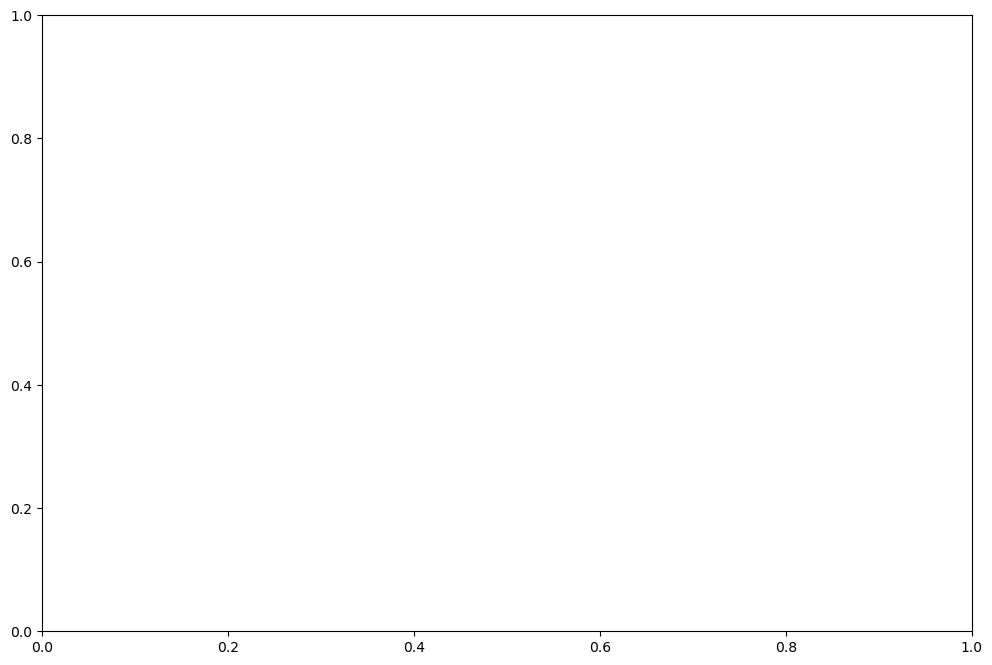

In [32]:
run_permutation_analysis(
    filename="unemployment_rate_by_age_groups.csv",
    config_name="test_config_yml",
    yaml=yaml_str_stat_reduce,
    n_permutations=10,
    n_bootstrap_row=10,
    n_bootstrap_col=10,
    n_perturbations=10,
    scale_factor=0.1,
    bootstrap_sample_fraction_row=0.9,
    bootstrap_sample_fraction_col=0.9,
    random_seed=42,
    skip=5,
    pdf_output="combined_analysis.pdf",
    normalize="z-score"
)

10 permutations, 10 row bootstrap samples, 10 column bootstrap samples, 10 perturbations
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 104.36it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 836.91it/s]


Calculation complete. Time taken: 0.0334s
Permutation analysis:


  0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 114.94it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 213.67it/s]


Calculation complete. Time taken: 0.0421s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.



Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 99.57it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 299.66it/s]



Calculation complete. Time taken: 0.0423s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 112.87it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 285.49it/s]



Calculation complete. Time taken: 0.0391s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 121.63it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 321.03it/s]



Calculation complete. Time taken: 0.0362s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 115.33it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 296.01it/s]



Calculation complete. Time taken: 0.0393s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 72.54it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 192.96it/s]



Calculation complete. Time taken: 0.0610s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 105.24it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 248.01it/s]



Calculation complete. Time taken: 0.0430s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 102.23it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 263.09it/s]



Calculation complete. Time taken: 0.0441s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 98.37it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 285.23it/s]



Calculation complete. Time taken: 0.0430s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 83.74it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 243.54it/s]


Calculation complete. Time taken: 0.0503s
Row bootstrap analysis:


Bootstrap sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 83.60it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 236.82it/s]



Calculation complete. Time taken: 0.0566s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 84.22it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 293.38it/s]



Calculation complete. Time taken: 0.0479s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 89.77it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 238.48it/s]



Calculation complete. Time taken: 0.0494s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 96.63it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 240.81it/s]



Calculation complete. Time taken: 0.0457s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 100.57it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 229.09it/s]



Calculation complete. Time taken: 0.0450s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 62.76it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 188.05it/s]



Calculation complete. Time taken: 0.0660s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 90.62it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 252.07it/s]



Calculation complete. Time taken: 0.0493s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 92.41it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 281.84it/s]



Calculation complete. Time taken: 0.0466s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 77.16it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 258.57it/s]



Calculation complete. Time taken: 0.0533s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 89.69it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 224.51it/s]



Calculation complete. Time taken: 0.0490s
Column bootstrap analysis (random columns):


Bootstrap sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 108.47it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 297.03it/s]



Calculation complete. Time taken: 0.0403s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 99.98it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 246.49it/s]



Calculation complete. Time taken: 0.0442s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 104.26it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 245.43it/s]



Calculation complete. Time taken: 0.0440s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 119.38it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 238.26it/s]



Calculation complete. Time taken: 0.0411s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 102.45it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 295.35it/s]



Calculation complete. Time taken: 0.0417s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 107.51it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 264.55it/s]



Calculation complete. Time taken: 0.0417s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 116.52it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 289.56it/s]



Calculation complete. Time taken: 0.0383s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 62.58it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 287.09it/s]



Calculation complete. Time taken: 0.0604s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 108.69it/s]
C:\Rishi\Maths\Research Project\py-spoc\pyspoc\reducers\basic.py:97: RuntimeWarning: divide by zero encountered in scalar power
  return det ** -data.ndim
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 302.34it/s]



Calculation complete. Time taken: 0.0396s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 114.01it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 269.68it/s]


Calculation complete. Time taken: 0.0398s
Perturbation analysis:



c:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Perturbation sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 93.56it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 291.37it/s]



Calculation complete. Time taken: 0.0445s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 85.42it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 333.68it/s]



Calculation complete. Time taken: 0.0463s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 99.47it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 281.98it/s]



Calculation complete. Time taken: 0.0428s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 102.44it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 233.97it/s]



Calculation complete. Time taken: 0.0435s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 102.04it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 136.09it/s]



Calculation complete. Time taken: 0.0545s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 95.94it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 324.72it/s]



Calculation complete. Time taken: 0.0426s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 91.94it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 347.32it/s]



Calculation complete. Time taken: 0.0433s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 101.16it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 259.02it/s]



Calculation complete. Time taken: 0.0433s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 99.95it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 158.24it/s]



Calculation complete. Time taken: 0.0510s
Registering YAML string.
Building internal configuration.
  ✔ Module pyspoc.statistics.basic already loaded.
    ✔ Statistic Covariance scheme 'cov' added successfully.
    ✔ Statistic KendallTau scheme 'sq' added successfully.
    ✔ Statistic KendallTau scheme 'standard' added successfully.
  ✔ Module pyspoc.reducers.basic already loaded.
    ✔ Reducer SingularValues scheme 'three' added successfully.
    ✔ Reducer Determinant scheme 'scaled' added successfully.
    ✔ Reducer Determinant scheme 'non-scaled' added successfully.


Processing [None: pyspoc.statistics.basic.KendallTau.standard]: 100%|██████████| 3/3 [00:00<00:00, 95.32it/s]
Processing [None: pyspoc.reducers.basic.Determinant.non-scaled]: 100%|██████████| 3/3 [00:00<00:00, 266.69it/s]



Calculation complete. Time taken: 0.0458s
Generating permutation distribution plots...
Generating row bootstrap distribution plots...


C:\Users\John\AppData\Local\Temp\ipykernel_3180\2212140565.py:182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Generating column bootstrap (random) distribution plots...
Error plotting bootstrap ('pyspoc.statistics.basic.Covariance.cov', 'pyspoc.reducers.basic.Determinant.scaled'): supplied range of [4.231130985396217e+36, inf] is not finite
Generating perturbation distribution plots...


{'permutation_results': {('pyspoc.statistics.basic.Covariance.cov',
   'pyspoc.reducers.basic.SingularValues.three_1'): {'value': 0.04617719419798359,
   'p_value': 0.2,
   'permutation_mean': 0.028350065422169602,
   'permutation_median': 0.03231804030880649,
   'permutation_std': 0.01675668430454743,
   'permutation_std_err': 0.0052989288434764446,
   'permutation_variance': 0.0002807864688822662,
   'permutation_min': 0.0063040596850173145,
   'permutation_max': 0.05107051219329077,
   'permutation_distribution': [0.05107051219329077,
    0.03555900100707327,
    0.009802962137311006,
    0.010208184163651653,
    0.0063040596850173145,
    0.04179752678999733,
    0.0290770796105397,
    0.044684230529898,
    0.009737494841566647,
    0.04525960326335033],
   'permutation_percentile_rank': 0.1},
  ('pyspoc.statistics.basic.Covariance.cov',
   'pyspoc.reducers.basic.SingularValues.three_2'): {'value': 0.0007139927659601103,
   'p_value': 0.4,
   'permutation_mean': 0.00054723273889

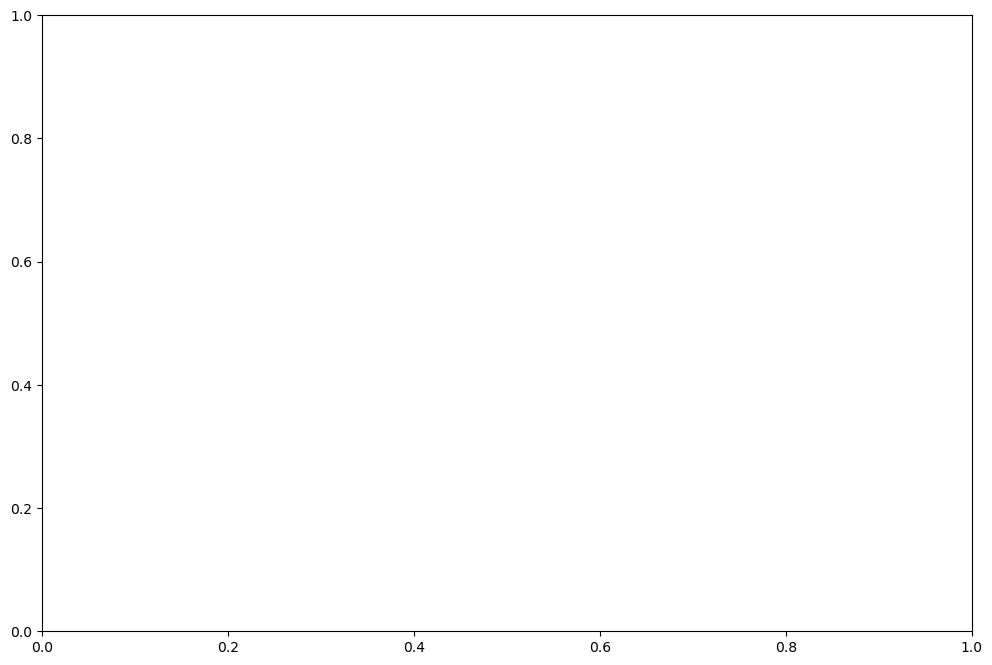

In [33]:
run_permutation_analysis(
    filename="DailyDelhiClimateTest.csv",
    config_name="test_config_yml",
    yaml=yaml_str_stat_reduce,
    n_permutations=10,
    n_bootstrap_row=10,
    n_bootstrap_col=10,
    n_perturbations=10,
    scale_factor=0.1,
    bootstrap_sample_fraction_row=0.9,
    bootstrap_sample_fraction_col=0.9,
    random_seed=42,
    skip=1,
    pdf_output="combined_analysis_daily_delhi.pdf",
    normalize="z-score"
)

## notes and debugg-y things (safely ignore)

In [34]:
# cfg = Config.from_internal("fast")
# - this is breaking - note